# Predicting Apartment Renting Prices in Santiago MR - Model Building

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
import seaborn as sns
import joblib
import pickle
import re
import os
from datetime import datetime
from time import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
import sklearn.metrics as metrics
import sklearn.utils
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import optuna

## Load Data: load training and test sets

Let's load the transformed training and test sets which we will use to train different models.

In [2]:
df_train = pd.read_csv("RENT_APARTMENT_RM_training_set.csv")
df_test = pd.read_csv("RENT_APARTMENT_RM_test_set.csv")

df_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Price
0,0.131886,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,620000.0
1,0.115192,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,730000.0
2,0.048414,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,300000.0
3,0.833055,3.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3900000.0
4,0.505843,4.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2950000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4042,0.148581,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,720000.0
4043,0.081803,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,571431.0
4044,0.186978,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1000000.0
4045,0.111853,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000000.0


## Define Feature sets

As we saw in the previous stage, the resulting training and test sets contain transformed columns whose relationship with the original feature columns are shown in the table below.

| Feature Column | Transformation | Transformed columns | 
| --- | --- | --- |
| Surface | MinMaxScaler | 0 | 
| Bedrooms | CustomOrdinalEncoder | 1 | 
| Bathrooms | CustomOrdinalEncoder | 2 | 
| Location | DimensionReducer + OneHotEncoder | 3 - 14 | 

We will now build different feature sets which will be used as predictors for the target feature *Price*, in a supervised regression learning task. The possible set of features will be considered as a hyperparameter and we will train four different type of models using the following algorithms:

- Multiple Regression
- LGBM Regressor
- XGBoost Regressor
- CatBoost Regressor

Here the goal is to assess the effect of including features of different character on the predictive power of the trained models. 
Depending on the type of features used for training, the trained models may have different usability, given that they will require different type of input data when used to make predictions in new data. <br>  

For each model type, the training will be done applying a 5-fold cross validation on the training set, and the hyperparameter optimization will be carried out using Optuna.
Next, we will use the test set to evaluate the best-performing models resulting from the optimized model training.

| Feature Set | Feature columns | 
| --- | --- |
| 1 | Surface | 
| 2 | Bedrooms | 
| 3 | Bathrooms | 
| 4 | Location | 
| 5 | Surface, Bedrooms | 
| 6 | Surface, Bathrooms | 
| 7 | Surface, Location | 
| 8 | Bedrooms, Bathrooms | 
| 9 | Bedrooms, Location |
| 10 | Bathrooms, Location |
| 11 | Surface, Bedrooms, Bathrooms |
| 12 | Surface, Bedrooms, Location |
| 13 | Surface, Bathrooms, Location | 
| 14 | Bedrooms, Bathrooms, Location | 
| 15 | Surface, Bedrooms, Bathrooms, Location | 

In [3]:
col_surface = ['0']
col_bedrooms = ['1']
col_bathrooms = ['2']
col_location = [str(i) for i in range(3, 15)]

features = {
    1: col_surface,
    2: col_bedrooms,
    3: col_bathrooms, 
    4: col_location,    
    #
    5: col_surface + col_bedrooms,
    6: col_surface + col_bathrooms,
    7: col_surface + col_location,
    8: col_bedrooms + col_bathrooms,
    9: col_bedrooms + col_location,
    10: col_bathrooms + col_location,
    #
    11: col_surface + col_bedrooms + col_bathrooms,
    12: col_surface + col_bedrooms + col_location,
    13: col_surface + col_bathrooms + col_location,
    14: col_bedrooms + col_bathrooms + col_location,
    15: col_surface + col_bedrooms + col_bathrooms + col_location,    
}

joblib.dump(features, "RENT_APARTMENT_RM_features.pkl")

['RENT_APARTMENT_RM_features.pkl']

In [4]:
print(len(features))
df_train[features[7]]

15


,0,3,4,5,6,7,8,9,10,11,12,13,14
0,0.131886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.115192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.048414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.833055,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.505843,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4042,0.148581,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4043,0.081803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4044,0.186978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4045,0.111853,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In order to evaluate the performance of the models being trained during the hyperparameter optimization process, we will consider the metrics listed below.

In [5]:
# see: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter   
metric_names = {
    'mae': 'neg_mean_absolute_error',
    'mse': 'neg_mean_squared_error',
    'rmse': 'neg_root_mean_squared_error',
    'msle': 'neg_mean_squared_log_error',
    'mape': 'neg_mean_absolute_percentage_error',
    'r2': 'r2',  
}
metric_names

{'mae': 'neg_mean_absolute_error',
 'mse': 'neg_mean_squared_error',
 'rmse': 'neg_root_mean_squared_error',
 'msle': 'neg_mean_squared_log_error',
 'mape': 'neg_mean_absolute_percentage_error',
 'r2': 'r2'}

In [6]:
def print_time(t):
    """
    Convert time period in seconds into %h:%m:%s expression.
    
    Parameters
    ----------
    t: int
        time period in seconds.
        
    Returns
    -------
    str
        time period formatted.         
    """
    h = t//3600
    m = (t%3600)//60
    s = (t%3600)%60
    return '%dh:%dm:%ds'%(h,m,s)

## Model training: Multiple Regression

In [7]:
def objective(trial):
    """
    Define objective function to be minimized in Optuna study for training a Multiple Regression model.
    
    Parameters
    ----------
    trial: instance of class optuna.trial.Trial
        Corresponds to a single execution of the objective function and is internally 
        instantiated upon each invocation of the objective function.
        
    Returns
    -------
    tuple
        Metric values evaluated in each optimization trial.         
    """    

    # sampled set of features 
    feature_set = trial.suggest_int('feature_set', 1, len(features))

    # model hyperparameters
    n_jobs = 2      
    
    params = {'n_jobs': n_jobs}
    
    model = linear_model.LinearRegression()  
    model.set_params(**params)
    
#     X_train = np.asanyarray(train_data[feature_set]['X_train'])
    X_train = np.asanyarray(df_train[features[feature_set]])    
    y_train = np.asanyarray(df_train['Price'])

    # objective metrics linked with the trial object.
    nfold = 5
    mae = -1 * np.mean(cross_val_score(model, X_train, y_train, cv=nfold, scoring=metric_names['mae'], verbose=0))
    mse = -1 * np.mean(cross_val_score(model, X_train, y_train, cv=nfold, scoring=metric_names['mse'], verbose=0))    
    rmse = -1 * np.mean(cross_val_score(model, X_train, y_train, cv=nfold, scoring=metric_names['rmse'], verbose=0))    
    mape = -1 * np.mean(cross_val_score(model, X_train, y_train, cv=nfold, scoring=metric_names['mape'], verbose=0))    
    
    return mae, mse, rmse, mape    

# start optuna study
RUN_LREG = True
if RUN_LREG:
    # create study
    lreg_study = optuna.create_study(
        directions=['minimize', 'minimize', 'minimize', 'minimize']
    )
    # optimize objective function
    start = time()
    n_trials = 100
    lreg_study.optimize(objective, n_trials=n_trials)
    print(f"\n Training time elapsed: {print_time(time()-start)}")

[I 2022-04-11 17:55:42,211] A new study created in memory with name: no-name-f0bb709e-0335-4bd4-91b6-3855d323176c
[I 2022-04-11 17:55:42,245] Trial 0 finished with values: [242496.14412685428, 185903179273.52527, 427378.6411322192, 0.2614337845441623] and parameters: {'feature_set': 5}. 
[I 2022-04-11 17:55:42,273] Trial 1 finished with values: [242496.14412685428, 185903179273.52527, 427378.6411322192, 0.2614337845441623] and parameters: {'feature_set': 5}. 
[I 2022-04-11 17:55:42,458] Trial 2 finished with values: [331166.66744989424, 294565614141.7311, 539719.4581303406, 0.35102242772016934] and parameters: {'feature_set': 10}. 
[I 2022-04-11 17:55:42,578] Trial 3 finished with values: [331378.0742609964, 294605741007.59906, 539786.6979813308, 0.35206166561621854] and parameters: {'feature_set': 14}. 
[I 2022-04-11 17:55:42,683] Trial 4 finished with values: [331166.66744989424, 294565614141.7311, 539719.4581303406, 0.35102242772016934] and parameters: {'feature_set': 10}. 
[I 2022-

[I 2022-04-11 17:55:46,124] Trial 43 finished with values: [241337.18913349038, 176030702103.9605, 416344.76021495333, 0.25021717299908924] and parameters: {'feature_set': 6}. 
[I 2022-04-11 17:55:46,213] Trial 44 finished with values: [210283.0343304825, 150916050549.61722, 385132.5933043553, 0.20519486761316164] and parameters: {'feature_set': 15}. 
[I 2022-04-11 17:55:46,304] Trial 45 finished with values: [215748.10120970913, 154768886020.21634, 390196.6460143467, 0.211642449510195] and parameters: {'feature_set': 13}. 
[I 2022-04-11 17:55:46,389] Trial 46 finished with values: [380868.2699393546, 444062792496.5248, 664016.7751595122, 0.36651406613837617] and parameters: {'feature_set': 4}. 
[I 2022-04-11 17:55:46,488] Trial 47 finished with values: [331378.0742609964, 294605741007.59906, 539786.6979813308, 0.35206166561621854] and parameters: {'feature_set': 14}. 
[I 2022-04-11 17:55:46,535] Trial 48 finished with values: [370068.1896046716, 342970592142.5937, 582690.4103785285, 0

[I 2022-04-11 17:55:50,089] Trial 87 finished with values: [215748.10120970913, 154768886020.21634, 390196.6460143467, 0.211642449510195] and parameters: {'feature_set': 13}. 
[I 2022-04-11 17:55:50,219] Trial 88 finished with values: [359997.1560195241, 358618813680.25055, 596478.0636146168, 0.380955847951097] and parameters: {'feature_set': 9}. 
[I 2022-04-11 17:55:50,316] Trial 89 finished with values: [215748.10120970913, 154768886020.21634, 390196.6460143467, 0.211642449510195] and parameters: {'feature_set': 13}. 
[I 2022-04-11 17:55:50,371] Trial 90 finished with values: [242496.14412685428, 185903179273.52527, 427378.6411322192, 0.2614337845441623] and parameters: {'feature_set': 5}. 
[I 2022-04-11 17:55:50,471] Trial 91 finished with values: [210283.0343304825, 150916050549.61722, 385132.5933043553, 0.20519486761316164] and parameters: {'feature_set': 15}. 
[I 2022-04-11 17:55:50,562] Trial 92 finished with values: [331166.66744989424, 294565614141.7311, 539719.4581303406, 0.3


 Training time elapsed: 0h:0m:9s


In [23]:
# lreg_study.best_value
# lreg_study.best_params
print(len(lreg_study.best_trials))
for t in lreg_study.best_trials:
    print(t)
# lreg_study.best_trials[0].values
for t in lreg_study.best_trials:
    print(t.values)

23
FrozenTrial(number=7, values=[211569.94489783453, 155655140841.56534, 391280.47760094283, 0.20254370186478762], datetime_start=datetime.datetime(2022, 4, 11, 17, 55, 42, 855034), datetime_complete=datetime.datetime(2022, 4, 11, 17, 55, 43, 513), params={'feature_set': 7}, distributions={'feature_set': IntUniformDistribution(high=15, low=1, step=1)}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, trial_id=7, state=TrialState.COMPLETE, value=None)
FrozenTrial(number=8, values=[211569.94489783453, 155655140841.56534, 391280.47760094283, 0.20254370186478762], datetime_start=datetime.datetime(2022, 4, 11, 17, 55, 43, 2038), datetime_complete=datetime.datetime(2022, 4, 11, 17, 55, 43, 150083), params={'feature_set': 7}, distributions={'feature_set': IntUniformDistribution(high=15, low=1, step=1)}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, trial_id=8, state=TrialState.COMPLETE, value=None)
FrozenTrial(number=10, values=[21156

In [9]:
joblib.dump(lreg_study, "optuna_lreg_study.pkl")

['optuna_lreg_study.pkl']

## Model training: LGBM Regressor

In [10]:
def objective(trial):
    """
    Define objective function to be minimized in Optuna study for training a LGBM Regressor model.
    
    Parameters
    ----------
    trial: instance of class optuna.trial.Trial
        Corresponds to a single execution of the objective function and is internally 
        instantiated upon each invocation of the objective function.
        
    Returns
    -------
    tuple
        Metric values evaluated in each optimization trial.         
    """  
    # sampled set of features 
    feature_set = trial.suggest_int('feature_set', 1, len(features))

    # model hyperparameters
    max_depth = trial.suggest_int('max_depth', 2, 10) # maximum depth of each tree
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e-1) # effect of each tree
    n_estimators = trial.suggest_int('n_estimators', 100, 3000) # number of trees (that is, boosting rounds)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10) # minimum number of houses in a leaf 
    colsample_bytree = trial.suggest_float("colsample_bytree", .2, 1.) # fraction of features (columns) per tree 
    subsample = trial.suggest_float("subsample", .2, 1.0) # fraction of instances (rows) per tree 
    reg_alpha = trial.suggest_float("reg_alpha", .0, 10.) # L1 regularization (like LASSO)
    reg_lambda = trial.suggest_float("reg_lambda", .0, 10.) # L2 regularization (like Ridge)
    #
#     random_state = 55,
    n_jobs = 2    
    
    params = {
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'n_estimators': n_estimators,
        'min_child_weight': min_child_weight,
        'colsample_bytree': colsample_bytree,
        'subsample': subsample,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
#         'random_state': random_state,
        'n_jobs': n_jobs
    }

    model = LGBMRegressor()  
    model.set_params(**params)
    
    X_train = np.asanyarray(df_train[features[feature_set]])    
    y_train = np.asanyarray(df_train['Price'])  

    # objective metrics linked with the trial object.
    nfold = 5
    mae = -1 * np.mean(cross_val_score(model, X_train, y_train, cv=nfold, scoring=metric_names['mae']))
    mse = -1 * np.mean(cross_val_score(model, X_train, y_train, cv=nfold, scoring=metric_names['mse']))    
    rmse = -1 * np.mean(cross_val_score(model, X_train, y_train, cv=nfold, scoring=metric_names['rmse']))    
    mape = -1 * np.mean(cross_val_score(model, X_train, y_train, cv=nfold, scoring=metric_names['mape']))    
    
    return mae, mse, rmse, mape  

# start optuna study
RUN_LGBM = True
if RUN_LGBM:
    # create study
    lgbm_study = optuna.create_study(
        directions=['minimize', 'minimize', 'minimize', 'minimize']
    )
    # optimize objective function
    start = time()
    n_trials = 500
    lgbm_study.optimize(objective, n_trials=n_trials)
    print(f"\n Training time elapsed: {print_time(time()-start)}")

[I 2022-04-11 17:58:19,913] A new study created in memory with name: no-name-9a26f416-0fb2-4836-ade0-1533076eee3d
[I 2022-04-11 17:58:39,522] Trial 0 finished with values: [266835.23887335975, 268735706608.36523, 515377.2489889186, 0.21154795306870416] and parameters: {'feature_set': 14, 'max_depth': 8, 'learning_rate': 0.07461166919266667, 'n_estimators': 2301, 'min_child_weight': 3, 'colsample_bytree': 0.9567544209646568, 'subsample': 0.47069101326471047, 'reg_alpha': 3.1623413978927584, 'reg_lambda': 5.210844689299288}. 
[I 2022-04-11 17:58:51,029] Trial 1 finished with values: [186477.7542999163, 134278915126.29349, 364115.1844208151, 0.16057220881335765] and parameters: {'feature_set': 15, 'max_depth': 8, 'learning_rate': 0.04697127528720239, 'n_estimators': 2043, 'min_child_weight': 6, 'colsample_bytree': 0.41236834430069397, 'subsample': 0.49386905204367776, 'reg_alpha': 4.877296268098318, 'reg_lambda': 3.429418126050047}. 
[I 2022-04-11 17:58:51,553] Trial 2 finished with value

[I 2022-04-11 18:00:16,964] Trial 19 finished with values: [415775.4038690417, 401429304499.766, 630125.1766995311, 0.5768579611185471] and parameters: {'feature_set': 11, 'max_depth': 3, 'learning_rate': 0.0011149778717566524, 'n_estimators': 730, 'min_child_weight': 6, 'colsample_bytree': 0.4097164113734496, 'subsample': 0.6366384656957396, 'reg_alpha': 3.4662049761166323, 'reg_lambda': 7.316442766851408}. 
[I 2022-04-11 18:00:27,176] Trial 20 finished with values: [269997.7407640166, 266949824778.68036, 514017.9930575768, 0.22077882218546466] and parameters: {'feature_set': 14, 'max_depth': 7, 'learning_rate': 0.006740645065303475, 'n_estimators': 2336, 'min_child_weight': 6, 'colsample_bytree': 0.3255910371738143, 'subsample': 0.7439909115636194, 'reg_alpha': 1.4523779529080683, 'reg_lambda': 1.6064422193444106}. 
[I 2022-04-11 18:00:33,707] Trial 21 finished with values: [446927.0898971958, 494594921495.45447, 701198.0423370369, 0.5157849144153752] and parameters: {'feature_set': 

[I 2022-04-11 18:02:45,403] Trial 39 finished with values: [231129.8199110934, 173488046707.98395, 412952.7038232978, 0.23237596180782477] and parameters: {'feature_set': 1, 'max_depth': 2, 'learning_rate': 0.013975760526945928, 'n_estimators': 1130, 'min_child_weight': 6, 'colsample_bytree': 0.3111736114634234, 'subsample': 0.3645012205166962, 'reg_alpha': 5.6510172362796425, 'reg_lambda': 6.347261531998514}. 
[I 2022-04-11 18:02:47,679] Trial 40 finished with values: [334024.5175571313, 289547907120.72174, 534110.2389278947, 0.44097968046251995] and parameters: {'feature_set': 15, 'max_depth': 3, 'learning_rate': 0.0015905869452505143, 'n_estimators': 832, 'min_child_weight': 6, 'colsample_bytree': 0.32388990335232903, 'subsample': 0.36151779663107475, 'reg_alpha': 6.966903830391205, 'reg_lambda': 0.7009343388200029}. 
[I 2022-04-11 18:02:48,485] Trial 41 finished with values: [191818.2056961198, 139040934411.84286, 369478.60502277664, 0.173714555918345] and parameters: {'feature_set

[I 2022-04-11 18:05:04,182] Trial 59 finished with values: [306261.1003663765, 333205966039.29865, 575025.082335545, 0.2524025304108565] and parameters: {'feature_set': 9, 'max_depth': 3, 'learning_rate': 0.052197959334059935, 'n_estimators': 1966, 'min_child_weight': 9, 'colsample_bytree': 0.6122408200117702, 'subsample': 0.4626087772496774, 'reg_alpha': 6.1433656851724, 'reg_lambda': 0.43243323506315323}. 
[I 2022-04-11 18:05:17,266] Trial 60 finished with values: [197737.86237224657, 144991634862.63574, 377360.0325064694, 0.1819200299809769] and parameters: {'feature_set': 7, 'max_depth': 6, 'learning_rate': 0.004314629648912276, 'n_estimators': 2739, 'min_child_weight': 3, 'colsample_bytree': 0.36371657465864615, 'subsample': 0.7406037067208426, 'reg_alpha': 2.903080860307826, 'reg_lambda': 0.9162860737088829}. 
[I 2022-04-11 18:05:26,397] Trial 61 finished with values: [223989.14727189663, 164777126313.64218, 402372.1335084952, 0.2242046454898885] and parameters: {'feature_set': 1

[I 2022-04-11 18:07:12,281] Trial 79 finished with values: [345459.08113539655, 289267022879.41675, 533755.2022392566, 0.4813041277187141] and parameters: {'feature_set': 5, 'max_depth': 8, 'learning_rate': 0.0015907701204846186, 'n_estimators': 555, 'min_child_weight': 10, 'colsample_bytree': 0.9609667421978538, 'subsample': 0.5514025305032246, 'reg_alpha': 5.919832412615992, 'reg_lambda': 2.8115269074383398}. 
[I 2022-04-11 18:07:13,749] Trial 80 finished with values: [540937.3256463873, 635284756034.0996, 794736.0310837601, 0.7575758580777283] and parameters: {'feature_set': 4, 'max_depth': 10, 'learning_rate': 0.0011768141156606284, 'n_estimators': 421, 'min_child_weight': 3, 'colsample_bytree': 0.7044604299512256, 'subsample': 0.23260365321989085, 'reg_alpha': 3.6169495222154016, 'reg_lambda': 0.9162860737088829}. 
[I 2022-04-11 18:07:20,923] Trial 81 finished with values: [202461.14230219452, 154446289286.8475, 388234.78049682314, 0.19151166540519018] and parameters: {'feature_se

[I 2022-04-11 18:09:30,395] Trial 99 finished with values: [344089.31602932885, 322774569621.1596, 565017.5964581531, 0.35127825653053646] and parameters: {'feature_set': 8, 'max_depth': 2, 'learning_rate': 0.04786818242144605, 'n_estimators': 377, 'min_child_weight': 5, 'colsample_bytree': 0.7713040687518486, 'subsample': 0.9686759709036015, 'reg_alpha': 6.3967497701773794, 'reg_lambda': 4.949288049836602}. 
[I 2022-04-11 18:09:39,381] Trial 100 finished with values: [185599.90285894574, 133776394271.63028, 362840.7520465317, 0.16202790036457954] and parameters: {'feature_set': 15, 'max_depth': 4, 'learning_rate': 0.012146331199138168, 'n_estimators': 2602, 'min_child_weight': 6, 'colsample_bytree': 0.7711618738059698, 'subsample': 0.8916415380503309, 'reg_alpha': 7.656577128114499, 'reg_lambda': 0.003740432156175144}. 
[I 2022-04-11 18:09:43,683] Trial 101 finished with values: [186636.37871034307, 133206358763.86185, 362118.4069239028, 0.16212586129935214] and parameters: {'feature_

[I 2022-04-11 18:11:24,598] Trial 119 finished with values: [224566.91081501025, 170457728805.95074, 409213.7041999897, 0.22345249332839404] and parameters: {'feature_set': 5, 'max_depth': 2, 'learning_rate': 0.06896655870195639, 'n_estimators': 2655, 'min_child_weight': 8, 'colsample_bytree': 0.5208196774069904, 'subsample': 0.770038549341681, 'reg_alpha': 3.1401740489824292, 'reg_lambda': 2.5803539341315784}. 
[I 2022-04-11 18:11:34,135] Trial 120 finished with values: [184937.37715985937, 131430848831.65308, 359785.83267510135, 0.16156387241346404] and parameters: {'feature_set': 15, 'max_depth': 4, 'learning_rate': 0.009662453605221357, 'n_estimators': 2602, 'min_child_weight': 6, 'colsample_bytree': 0.9681279429425143, 'subsample': 0.5514025305032246, 'reg_alpha': 5.37365842096886, 'reg_lambda': 5.225988766278904}. 
[I 2022-04-11 18:11:34,973] Trial 121 finished with values: [223135.44997881507, 161928055301.9081, 397782.66409729247, 0.24442343063289176] and parameters: {'feature_

[I 2022-04-11 18:13:30,063] Trial 139 finished with values: [191440.56111089818, 142277202586.76816, 373669.5271363161, 0.16786208398712243] and parameters: {'feature_set': 13, 'max_depth': 4, 'learning_rate': 0.005879461441507535, 'n_estimators': 2304, 'min_child_weight': 2, 'colsample_bytree': 0.8723587342356953, 'subsample': 0.3822535375536427, 'reg_alpha': 6.531555041353235, 'reg_lambda': 8.276967187703995}. 
[I 2022-04-11 18:13:41,013] Trial 140 finished with values: [190206.25359224324, 142676658904.51385, 374325.79227644205, 0.16525378434501978] and parameters: {'feature_set': 13, 'max_depth': 9, 'learning_rate': 0.004859028338207167, 'n_estimators': 1258, 'min_child_weight': 6, 'colsample_bytree': 0.7713040687518486, 'subsample': 0.21897715647039853, 'reg_alpha': 1.9855085116221804, 'reg_lambda': 2.8115269074383398}. 
[I 2022-04-11 18:13:58,277] Trial 141 finished with values: [192392.1226638207, 145967508327.81876, 378475.9638156199, 0.168731839709751] and parameters: {'featur

[I 2022-04-11 18:16:15,278] Trial 159 finished with values: [184963.72408803954, 135172140150.0994, 363746.764521865, 0.1633018824853045] and parameters: {'feature_set': 15, 'max_depth': 6, 'learning_rate': 0.006205183453551145, 'n_estimators': 1114, 'min_child_weight': 10, 'colsample_bytree': 0.9439549773295848, 'subsample': 0.45371494224927605, 'reg_alpha': 6.271984899336579, 'reg_lambda': 6.3826064846322605}. 
[I 2022-04-11 18:16:16,105] Trial 160 finished with values: [192095.14239554302, 139549149043.9785, 370035.7124488236, 0.17425517632541596] and parameters: {'feature_set': 15, 'max_depth': 2, 'learning_rate': 0.04786818242144605, 'n_estimators': 377, 'min_child_weight': 5, 'colsample_bytree': 0.7713040687518486, 'subsample': 0.8093158512970793, 'reg_alpha': 8.134014676426078, 'reg_lambda': 6.3826064846322605}. 
[I 2022-04-11 18:16:21,242] Trial 161 finished with values: [184454.31963212747, 130853609637.87544, 359669.22362054157, 0.1583092401364623] and parameters: {'feature_s

[I 2022-04-11 18:18:53,213] Trial 179 finished with values: [221981.14968864378, 168737684654.5145, 405546.95944013447, 0.2468075140923474] and parameters: {'feature_set': 15, 'max_depth': 5, 'learning_rate': 0.0013798702658420776, 'n_estimators': 1485, 'min_child_weight': 8, 'colsample_bytree': 0.6498121338124385, 'subsample': 0.6648286029677842, 'reg_alpha': 1.386696031408895, 'reg_lambda': 6.3826064846322605}. 
[I 2022-04-11 18:19:00,743] Trial 180 finished with values: [186687.71160499827, 133699162939.3945, 363124.9909336014, 0.16121287516738284] and parameters: {'feature_set': 15, 'max_depth': 5, 'learning_rate': 0.052197959334059935, 'n_estimators': 1692, 'min_child_weight': 6, 'colsample_bytree': 0.4561037351823318, 'subsample': 0.4626087772496774, 'reg_alpha': 6.1433656851724, 'reg_lambda': 3.429418126050047}. 
[I 2022-04-11 18:19:07,532] Trial 181 finished with values: [185230.84711959993, 132504296844.21982, 361747.0722362158, 0.15965153824656178] and parameters: {'feature_s

[I 2022-04-11 18:20:46,270] Trial 199 finished with values: [381049.9023358412, 444051401798.64813, 664006.4805955866, 0.36735260344031795] and parameters: {'feature_set': 4, 'max_depth': 4, 'learning_rate': 0.012146331199138168, 'n_estimators': 1094, 'min_child_weight': 9, 'colsample_bytree': 0.8123389902762763, 'subsample': 0.6930848025881042, 'reg_alpha': 0.7240545794555309, 'reg_lambda': 0.003740432156175144}. 
[I 2022-04-11 18:20:50,573] Trial 200 finished with values: [185120.94298832834, 131030928890.65242, 359945.386780197, 0.15932410868905464] and parameters: {'feature_set': 15, 'max_depth': 5, 'learning_rate': 0.0711623541130355, 'n_estimators': 1057, 'min_child_weight': 6, 'colsample_bytree': 0.9681279429425143, 'subsample': 0.5514025305032246, 'reg_alpha': 5.37365842096886, 'reg_lambda': 5.225988766278904}. 
[I 2022-04-11 18:20:53,508] Trial 201 finished with values: [187796.5490020031, 136604582293.13383, 366613.57434403355, 0.16395951272068904] and parameters: {'feature_s

[I 2022-04-11 18:23:22,433] Trial 219 finished with values: [189885.27326799062, 140115164066.62338, 371085.8151472231, 0.16503653196432688] and parameters: {'feature_set': 13, 'max_depth': 5, 'learning_rate': 0.03458067025950221, 'n_estimators': 585, 'min_child_weight': 10, 'colsample_bytree': 0.855239243939663, 'subsample': 0.8479739762896032, 'reg_alpha': 8.92564301789096, 'reg_lambda': 4.389444956937303}. 
[I 2022-04-11 18:23:27,648] Trial 220 finished with values: [273856.7707103816, 270026149767.69327, 516888.36608840787, 0.22677402032156202] and parameters: {'feature_set': 10, 'max_depth': 2, 'learning_rate': 0.06896655870195639, 'n_estimators': 2543, 'min_child_weight': 6, 'colsample_bytree': 0.7713040687518486, 'subsample': 0.7400253931076004, 'reg_alpha': 1.0353673998986246, 'reg_lambda': 4.605609974280341}. 
[I 2022-04-11 18:23:33,431] Trial 221 finished with values: [186312.50918305494, 132836569532.11621, 361563.7246213452, 0.16314166975106495] and parameters: {'feature_se

[I 2022-04-11 18:26:04,544] Trial 239 finished with values: [192183.77687088656, 136989878940.84038, 366887.6580617595, 0.17179879232531428] and parameters: {'feature_set': 15, 'max_depth': 4, 'learning_rate': 0.012146331199138168, 'n_estimators': 2602, 'min_child_weight': 6, 'colsample_bytree': 0.21120948781853263, 'subsample': 0.49386905204367776, 'reg_alpha': 5.37365842096886, 'reg_lambda': 5.225988766278904}. 
[I 2022-04-11 18:26:13,981] Trial 240 finished with values: [189278.63696575086, 140231736374.4342, 370027.22323954443, 0.17470557594642602] and parameters: {'feature_set': 15, 'max_depth': 5, 'learning_rate': 0.002559854573386249, 'n_estimators': 1485, 'min_child_weight': 9, 'colsample_bytree': 0.9212202488308991, 'subsample': 0.8479739762896032, 'reg_alpha': 7.656577128114499, 'reg_lambda': 6.3826064846322605}. 
[I 2022-04-11 18:26:16,159] Trial 241 finished with values: [206077.97104461855, 148501448245.15106, 381740.7792943999, 0.18982422693475925] and parameters: {'featu

[I 2022-04-11 18:28:29,682] Trial 259 finished with values: [214199.60392167495, 154276919833.55878, 390507.36965265276, 0.20560580077379687] and parameters: {'feature_set': 11, 'max_depth': 5, 'learning_rate': 0.04697127528720239, 'n_estimators': 2939, 'min_child_weight': 6, 'colsample_bytree': 0.9439549773295848, 'subsample': 0.401316938951571, 'reg_alpha': 1.386696031408895, 'reg_lambda': 6.3826064846322605}. 
[I 2022-04-11 18:28:42,420] Trial 260 finished with values: [185089.526980443, 132958844007.8274, 362459.04750309145, 0.1590602609474508] and parameters: {'feature_set': 15, 'max_depth': 6, 'learning_rate': 0.03458067025950221, 'n_estimators': 2739, 'min_child_weight': 10, 'colsample_bytree': 0.9212202488308991, 'subsample': 0.8479739762896032, 'reg_alpha': 7.656577128114499, 'reg_lambda': 6.3826064846322605}. 
[I 2022-04-11 18:28:45,803] Trial 261 finished with values: [195387.81232776472, 138444032935.87787, 368775.6546243017, 0.1759905595782341] and parameters: {'feature_se

[I 2022-04-11 18:31:00,716] Trial 279 finished with values: [185019.0111837032, 131907172706.51123, 361119.7389579072, 0.1591156522455504] and parameters: {'feature_set': 15, 'max_depth': 5, 'learning_rate': 0.03458067025950221, 'n_estimators': 2602, 'min_child_weight': 10, 'colsample_bytree': 0.9439549773295848, 'subsample': 0.8479739762896032, 'reg_alpha': 7.656577128114499, 'reg_lambda': 8.239250395364026}. 
[I 2022-04-11 18:31:13,411] Trial 280 finished with values: [187092.49867259758, 137896942209.59003, 369551.8041340667, 0.16024706009509654] and parameters: {'feature_set': 15, 'max_depth': 6, 'learning_rate': 0.06896655870195639, 'n_estimators': 2739, 'min_child_weight': 4, 'colsample_bytree': 0.9439549773295848, 'subsample': 0.9686759709036015, 'reg_alpha': 1.9691206121175953, 'reg_lambda': 6.3826064846322605}. 
[I 2022-04-11 18:31:17,971] Trial 281 finished with values: [184684.40068087456, 131204275024.93123, 360028.3460648873, 0.1600515907979601] and parameters: {'feature_s

[I 2022-04-11 18:33:30,678] Trial 299 finished with values: [184489.66383797798, 130312177125.02747, 358638.05286501674, 0.1596772764266114] and parameters: {'feature_set': 15, 'max_depth': 4, 'learning_rate': 0.04786818242144605, 'n_estimators': 780, 'min_child_weight': 2, 'colsample_bytree': 0.9688525412060367, 'subsample': 0.45371494224927605, 'reg_alpha': 1.3745416491706441, 'reg_lambda': 0.9579393426307115}. 
[I 2022-04-11 18:33:41,857] Trial 300 finished with values: [184651.1306338829, 133050636851.16768, 361754.63108434086, 0.1613674609593909] and parameters: {'feature_set': 15, 'max_depth': 5, 'learning_rate': 0.009662453605221357, 'n_estimators': 2602, 'min_child_weight': 10, 'colsample_bytree': 0.9439549773295848, 'subsample': 0.6624754738590455, 'reg_alpha': 7.656577128114499, 'reg_lambda': 6.3826064846322605}. 
[I 2022-04-11 18:33:44,787] Trial 301 finished with values: [188522.17198959575, 137052204086.46841, 366620.0072185651, 0.16841780275298007] and parameters: {'featu

[I 2022-04-11 18:35:57,249] Trial 319 finished with values: [184734.80502890135, 132439062903.28354, 361236.67628856644, 0.1604360831951434] and parameters: {'feature_set': 15, 'max_depth': 5, 'learning_rate': 0.012146331199138168, 'n_estimators': 2806, 'min_child_weight': 9, 'colsample_bytree': 0.9439549773295848, 'subsample': 0.5437507593103985, 'reg_alpha': 5.65444137118541, 'reg_lambda': 5.225988766278904}. 
[I 2022-04-11 18:36:05,999] Trial 320 finished with values: [189565.1639132273, 139605765390.54266, 371382.47514451074, 0.16369221391296626] and parameters: {'feature_set': 13, 'max_depth': 4, 'learning_rate': 0.023382249186061167, 'n_estimators': 2602, 'min_child_weight': 2, 'colsample_bytree': 0.9439549773295848, 'subsample': 0.5514025305032246, 'reg_alpha': 5.37365842096886, 'reg_lambda': 6.3826064846322605}. 
[I 2022-04-11 18:36:19,918] Trial 321 finished with values: [184347.33923303962, 131985312073.34326, 360965.9001085424, 0.16073930553705934] and parameters: {'feature_

[I 2022-04-11 18:39:00,465] Trial 339 finished with values: [184336.76837751962, 132483159650.26363, 361334.5658954852, 0.16009205466145224] and parameters: {'feature_set': 15, 'max_depth': 5, 'learning_rate': 0.06896655870195639, 'n_estimators': 728, 'min_child_weight': 5, 'colsample_bytree': 0.9439549773295848, 'subsample': 0.6648286029677842, 'reg_alpha': 3.1401740489824292, 'reg_lambda': 6.3826064846322605}. 
[I 2022-04-11 18:39:05,075] Trial 340 finished with values: [186007.2097092507, 133155366268.50137, 362862.4093881306, 0.1589212489311766] and parameters: {'feature_set': 15, 'max_depth': 5, 'learning_rate': 0.0838625653015087, 'n_estimators': 1167, 'min_child_weight': 3, 'colsample_bytree': 0.9439549773295848, 'subsample': 0.8479739762896032, 'reg_alpha': 1.386696031408895, 'reg_lambda': 0.20230629356188579}. 
[I 2022-04-11 18:39:06,985] Trial 341 finished with values: [344831.03759734763, 323993352793.7637, 566004.5155927355, 0.35420458283842865] and parameters: {'feature_se

[I 2022-04-11 18:41:22,584] Trial 359 finished with values: [184711.4011965618, 131532209082.7375, 360300.9013192469, 0.16019005986287072] and parameters: {'feature_set': 15, 'max_depth': 4, 'learning_rate': 0.023382249186061167, 'n_estimators': 2043, 'min_child_weight': 6, 'colsample_bytree': 0.9315526900199467, 'subsample': 0.49386905204367776, 'reg_alpha': 1.0353673998986246, 'reg_lambda': 2.8595950461649644}. 
[I 2022-04-11 18:41:33,838] Trial 360 finished with values: [184361.89372199716, 132121931129.10161, 360641.2257522081, 0.16049336364479908] and parameters: {'feature_set': 15, 'max_depth': 5, 'learning_rate': 0.009662453605221357, 'n_estimators': 2602, 'min_child_weight': 8, 'colsample_bytree': 0.9439549773295848, 'subsample': 0.2757037772611619, 'reg_alpha': 4.877296268098318, 'reg_lambda': 3.429418126050047}. 
[I 2022-04-11 18:41:35,783] Trial 361 finished with values: [184694.7047598135, 130472915256.43106, 358670.4910742929, 0.16036377478989589] and parameters: {'feature

[I 2022-04-11 18:44:32,873] Trial 379 finished with values: [186652.1871987141, 134717308920.54813, 365203.4936163613, 0.1594096298593686] and parameters: {'feature_set': 15, 'max_depth': 5, 'learning_rate': 0.0711623541130355, 'n_estimators': 2602, 'min_child_weight': 9, 'colsample_bytree': 0.9212202488308991, 'subsample': 0.5437507593103985, 'reg_alpha': 5.37365842096886, 'reg_lambda': 5.225988766278904}. 
[I 2022-04-11 18:44:36,941] Trial 380 finished with values: [184733.01140100617, 130698561834.40462, 359467.8135612354, 0.15874657263249806] and parameters: {'feature_set': 15, 'max_depth': 5, 'learning_rate': 0.06896655870195639, 'n_estimators': 1057, 'min_child_weight': 6, 'colsample_bytree': 0.9681279429425143, 'subsample': 0.5514025305032246, 'reg_alpha': 5.37365842096886, 'reg_lambda': 1.3714120782642125}. 
[I 2022-04-11 18:44:42,177] Trial 381 finished with values: [185423.69653993184, 134115575041.64034, 362805.30303982703, 0.16300796133144493] and parameters: {'feature_set'

[I 2022-04-11 18:47:36,721] Trial 399 finished with values: [183994.11117029356, 134101304832.06042, 362807.27380007214, 0.16088983709159715] and parameters: {'feature_set': 15, 'max_depth': 8, 'learning_rate': 0.009662453605221357, 'n_estimators': 1114, 'min_child_weight': 4, 'colsample_bytree': 0.9212202488308991, 'subsample': 0.6648286029677842, 'reg_alpha': 1.0353673998986246, 'reg_lambda': 2.848019223288661}. 
[I 2022-04-11 18:47:48,399] Trial 400 finished with values: [184478.6150726617, 134324829723.23242, 363500.4396069645, 0.1605517854008522] and parameters: {'feature_set': 15, 'max_depth': 8, 'learning_rate': 0.006505031783221276, 'n_estimators': 1485, 'min_child_weight': 4, 'colsample_bytree': 0.9212202488308991, 'subsample': 0.8479739762896032, 'reg_alpha': 1.9691206121175953, 'reg_lambda': 0.003740432156175144}. 
[I 2022-04-11 18:47:57,465] Trial 401 finished with values: [184334.9948572999, 130204682736.75142, 358454.7358081127, 0.159834990909499] and parameters: {'featur

[I 2022-04-11 18:50:47,055] Trial 419 finished with values: [184695.94186558452, 131355182425.90466, 360367.26312944794, 0.15834743768365941] and parameters: {'feature_set': 15, 'max_depth': 5, 'learning_rate': 0.0711623541130355, 'n_estimators': 1057, 'min_child_weight': 2, 'colsample_bytree': 0.9439549773295848, 'subsample': 0.5514025305032246, 'reg_alpha': 7.656577128114499, 'reg_lambda': 0.13364766180431809}. 
[I 2022-04-11 18:50:56,443] Trial 420 finished with values: [184792.13708294896, 132109824827.25505, 360691.5078811237, 0.16154553186373538] and parameters: {'feature_set': 15, 'max_depth': 4, 'learning_rate': 0.012146331199138168, 'n_estimators': 2739, 'min_child_weight': 7, 'colsample_bytree': 0.9439549773295848, 'subsample': 0.6648286029677842, 'reg_alpha': 7.656577128114499, 'reg_lambda': 6.3826064846322605}. 
[I 2022-04-11 18:51:05,037] Trial 421 finished with values: [184688.14276491734, 131898010174.64864, 360856.7558368263, 0.15975047396888595] and parameters: {'featu

[I 2022-04-11 18:53:00,792] Trial 439 finished with values: [184853.18552541034, 131254701816.96829, 360059.7647237139, 0.16012123044203472] and parameters: {'feature_set': 15, 'max_depth': 3, 'learning_rate': 0.03458067025950221, 'n_estimators': 1858, 'min_child_weight': 4, 'colsample_bytree': 0.9212202488308991, 'subsample': 0.8479739762896032, 'reg_alpha': 1.9691206121175953, 'reg_lambda': 4.389444956937303}. 
[I 2022-04-11 18:53:09,845] Trial 440 finished with values: [184659.60019262508, 132130077482.11404, 360799.82090593496, 0.1610370839658712] and parameters: {'feature_set': 15, 'max_depth': 4, 'learning_rate': 0.012146331199138168, 'n_estimators': 2602, 'min_child_weight': 4, 'colsample_bytree': 0.9681279429425143, 'subsample': 0.5514025305032246, 'reg_alpha': 5.37365842096886, 'reg_lambda': 9.52328177197196}. 
[I 2022-04-11 18:53:16,989] Trial 441 finished with values: [183800.64287906734, 131976999771.92024, 360867.9415574911, 0.15911009734586679] and parameters: {'feature_s

[I 2022-04-11 18:55:54,869] Trial 459 finished with values: [184730.27534548854, 132223738057.10014, 361012.7755797799, 0.1606326204487738] and parameters: {'feature_set': 15, 'max_depth': 4, 'learning_rate': 0.04786818242144605, 'n_estimators': 780, 'min_child_weight': 2, 'colsample_bytree': 0.9688525412060367, 'subsample': 0.45371494224927605, 'reg_alpha': 1.3745416491706441, 'reg_lambda': 9.790386323848535}. 
[I 2022-04-11 18:56:12,423] Trial 460 finished with values: [183464.34849366604, 133415428110.1611, 362527.5056383469, 0.15971507773589427] and parameters: {'feature_set': 15, 'max_depth': 8, 'learning_rate': 0.009662453605221357, 'n_estimators': 2602, 'min_child_weight': 2, 'colsample_bytree': 0.9439549773295848, 'subsample': 0.6648286029677842, 'reg_alpha': 7.656577128114499, 'reg_lambda': 6.3826064846322605}. 
[I 2022-04-11 18:56:21,542] Trial 461 finished with values: [184354.60605428898, 130189730826.62906, 358464.6587334725, 0.15981317124092315] and parameters: {'feature_

[I 2022-04-11 18:58:42,189] Trial 479 finished with values: [273276.48513428995, 271264333568.93262, 517818.6832314905, 0.22517479562209824] and parameters: {'feature_set': 10, 'max_depth': 4, 'learning_rate': 0.07661928146007636, 'n_estimators': 2602, 'min_child_weight': 10, 'colsample_bytree': 0.9681279429425143, 'subsample': 0.5514025305032246, 'reg_alpha': 5.37365842096886, 'reg_lambda': 0.9579393426307115}. 
[I 2022-04-11 18:58:48,951] Trial 480 finished with values: [185189.31995779191, 131131556043.89493, 359473.8995604528, 0.16151538296207235] and parameters: {'feature_set': 15, 'max_depth': 4, 'learning_rate': 0.012059216581117953, 'n_estimators': 1882, 'min_child_weight': 4, 'colsample_bytree': 0.9681279429425143, 'subsample': 0.45371494224927605, 'reg_alpha': 1.3745416491706441, 'reg_lambda': 0.9579393426307115}. 
[I 2022-04-11 18:58:51,956] Trial 481 finished with values: [184944.91134802368, 131508131540.70427, 360511.95300849836, 0.15862604591029536] and parameters: {'fea

[I 2022-04-11 19:02:16,608] Trial 499 finished with values: [186055.40389372106, 132578713634.59726, 361185.34901971486, 0.16297508263434662] and parameters: {'feature_set': 15, 'max_depth': 4, 'learning_rate': 0.012146331199138168, 'n_estimators': 1613, 'min_child_weight': 9, 'colsample_bytree': 0.9439549773295848, 'subsample': 0.8479739762896032, 'reg_alpha': 7.656577128114499, 'reg_lambda': 0.9579393426307115}. 



 Training time elapsed: 1h:3m:56s


In [31]:
print(len(lgbm_study.best_trials))
for t in lgbm_study.best_trials:
    print(t)
for t in lgbm_study.best_trials:
    print(t.number, t.values)

18
FrozenTrial(number=161, values=[184454.31963212747, 130853609637.87544, 359669.22362054157, 0.1583092401364623], datetime_start=datetime.datetime(2022, 4, 11, 18, 16, 16, 106320), datetime_complete=datetime.datetime(2022, 4, 11, 18, 16, 21, 242252), params={'feature_set': 15, 'max_depth': 4, 'learning_rate': 0.04786818242144605, 'n_estimators': 1485, 'min_child_weight': 4, 'colsample_bytree': 0.9688525412060367, 'subsample': 0.45371494224927605, 'reg_alpha': 1.9691206121175953, 'reg_lambda': 0.9579393426307115}, distributions={'feature_set': IntUniformDistribution(high=15, low=1, step=1), 'max_depth': IntUniformDistribution(high=10, low=2, step=1), 'learning_rate': LogUniformDistribution(high=0.1, low=0.001), 'n_estimators': IntUniformDistribution(high=3000, low=100, step=1), 'min_child_weight': IntUniformDistribution(high=10, low=1, step=1), 'colsample_bytree': UniformDistribution(high=1.0, low=0.2), 'subsample': UniformDistribution(high=1.0, low=0.2), 'reg_alpha': UniformDistribut

161 [184454.31963212747, 130853609637.87544, 359669.22362054157, 0.1583092401364623]
229 [184387.16739654285, 130428505301.04907, 358953.99562012136, 0.1591218901369138]
318 [184527.251874368, 130791021440.97542, 359585.024184917, 0.15839622783150215]
336 [184200.43826788463, 130831707905.47415, 359683.8379594179, 0.15805290721919624]
355 [184173.2355897467, 130185752759.65215, 358479.0665009199, 0.1595163120079533]
370 [184470.07322006414, 130296910268.31046, 358423.00739272835, 0.160382148161139]
401 [184334.9948572999, 130204682736.75142, 358454.7358081127, 0.159834990909499]
405 [183995.88290151922, 130435219443.45259, 358654.2413727211, 0.15961439686181783]
409 [184527.251874368, 130791021440.97542, 359585.024184917, 0.15839622783150215]
412 [183368.46694610728, 132506349444.12798, 361234.58024059486, 0.15929387136776213]
416 [184387.16739654285, 130428505301.04907, 358953.99562012136, 0.1591218901369138]
441 [183800.64287906734, 131976999771.92024, 360867.9415574911, 0.1591100973

In [12]:
joblib.dump(lgbm_study, "optuna_lgbm_study.pkl")

['optuna_lgbm_study.pkl']

## Model training: XGBoost Regressor

In [13]:
def objective(trial):
    """
    Define objective function to be minimized in Optuna study for training a XGBoost Regressor model.
    
    Parameters
    ----------
    trial: instance of class optuna.trial.Trial
        Corresponds to a single execution of the objective function and is internally 
        instantiated upon each invocation of the objective function.
        
    Returns
    -------
    tuple
        Metric values evaluated in each optimization trial.         
    """      
    # sampled set of features 
    feature_set = trial.suggest_int('feature_set', 1, len(features))

    # model hyperparameters
    max_depth = trial.suggest_int('max_depth', 2, 10) # maximum depth of each tree
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e-1) # effect of each tree
    n_estimators = trial.suggest_int('n_estimators', 100, 3000) # number of trees (that is, boosting rounds)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10) # minimum number of houses in a leaf 
    colsample_bytree = trial.suggest_float("colsample_bytree", .2, 1.) # fraction of features (columns) per tree 
    subsample = trial.suggest_float("subsample", .2, 1.0) # fraction of instances (rows) per tree 
    reg_alpha = trial.suggest_float("reg_alpha", .0, 10.) # L1 regularization (like LASSO)
    reg_lambda = trial.suggest_float("reg_lambda", .0, 10.) # L2 regularization (like Ridge)
#         num_parallel_tree = trial.suggest_int('num_parallel_tree', 1, 3) # set > 1 for boosted random forests
    #
#     random_state = 55,
#     predictor = 'cpu_predictor',
    n_jobs = 2    
    
    params = {
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'n_estimators': n_estimators,
        'min_child_weight': min_child_weight,
        'colsample_bytree': colsample_bytree,
        'subsample': subsample,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
# #         num_parallel_tree = num_parallel_tree,
#         'random_state': random_state,
#         'predictor': predictor,
        'n_jobs': n_jobs
    }

    model = XGBRegressor()  
    model.set_params(**params)
    
    X_train = np.asanyarray(df_train[features[feature_set]])    
    y_train = np.asanyarray(df_train['Price'])    

    # objective metrics linked with the trial object.
    nfold = 5
    mae = -1 * np.mean(cross_val_score(model, X_train, y_train, cv=nfold, scoring=metric_names['mae']))
    mse = -1 * np.mean(cross_val_score(model, X_train, y_train, cv=nfold, scoring=metric_names['mse']))    
    rmse = -1 * np.mean(cross_val_score(model, X_train, y_train, cv=nfold, scoring=metric_names['rmse']))    
    mape = -1 * np.mean(cross_val_score(model, X_train, y_train, cv=nfold, scoring=metric_names['mape']))    
    
    return mae, mse, rmse, mape   

# start optuna study
RUN_XGB = True
if RUN_XGB:
    # create study
    xgb_study = optuna.create_study(
        directions=['minimize', 'minimize', 'minimize', 'minimize']
    )
    # optimize objective function
    start = time()
    n_trials = 500
    xgb_study.optimize(objective, n_trials=n_trials)
    print(f"\n Training time elapsed: {print_time(time()-start)}")

[I 2022-04-11 19:06:09,068] A new study created in memory with name: no-name-5eb40955-b203-4a8a-b101-17b2e5c6a6a9
[I 2022-04-11 19:06:11,161] Trial 0 finished with values: [419762.01577956893, 583815490290.8723, 760888.5304807386, 0.317484052678075] and parameters: {'feature_set': 8, 'max_depth': 9, 'learning_rate': 0.0031828197202464856, 'n_estimators': 307, 'min_child_weight': 4, 'colsample_bytree': 0.3827876354747809, 'subsample': 0.9926429136574488, 'reg_alpha': 1.633238815508472, 'reg_lambda': 4.378150112230887}. 
[I 2022-04-11 19:07:31,704] Trial 1 finished with values: [184433.3705517309, 144053374332.59088, 374725.4711629166, 0.15774705419729546] and parameters: {'feature_set': 12, 'max_depth': 9, 'learning_rate': 0.002005751016641429, 'n_estimators': 1956, 'min_child_weight': 10, 'colsample_bytree': 0.9558539987448702, 'subsample': 0.8292244474257864, 'reg_alpha': 2.612141847127405, 'reg_lambda': 6.556650427480653}. 
[I 2022-04-11 19:07:47,984] Trial 2 finished with values: [3

[I 2022-04-11 19:13:48,814] Trial 19 finished with values: [268152.7212059832, 267718307625.06488, 514657.3253290945, 0.21435289120334908] and parameters: {'feature_set': 14, 'max_depth': 8, 'learning_rate': 0.08440400350259765, 'n_estimators': 2481, 'min_child_weight': 3, 'colsample_bytree': 0.2403972426204513, 'subsample': 0.2797295896802199, 'reg_alpha': 1.7534076851412495, 'reg_lambda': 8.030658025735894}. 
[I 2022-04-11 19:14:09,413] Trial 20 finished with values: [235133.5042153856, 175570685739.81573, 414805.9546224149, 0.2410409876829457] and parameters: {'feature_set': 11, 'max_depth': 3, 'learning_rate': 0.009080143184779121, 'n_estimators': 2776, 'min_child_weight': 5, 'colsample_bytree': 0.6403311697909052, 'subsample': 0.9805813660017453, 'reg_alpha': 4.216595646638609, 'reg_lambda': 5.818825257313945}. 
[I 2022-04-11 19:14:21,644] Trial 21 finished with values: [268102.22553190193, 266889411471.9589, 513915.90273023676, 0.21505342285079115] and parameters: {'feature_set':

[I 2022-04-11 19:24:28,069] Trial 39 finished with values: [344759.00252854655, 322589325845.462, 564779.8544326347, 0.3539547452072076] and parameters: {'feature_set': 8, 'max_depth': 4, 'learning_rate': 0.036216435868515084, 'n_estimators': 1606, 'min_child_weight': 7, 'colsample_bytree': 0.20865343552866458, 'subsample': 0.806039506344377, 'reg_alpha': 5.357831508884098, 'reg_lambda': 7.641706297759294}. 
[I 2022-04-11 19:24:49,640] Trial 40 finished with values: [380998.272121017, 444148667024.54456, 664088.9610850194, 0.36642421201226083] and parameters: {'feature_set': 4, 'max_depth': 2, 'learning_rate': 0.043006880548399615, 'n_estimators': 2136, 'min_child_weight': 4, 'colsample_bytree': 0.8193498437908564, 'subsample': 0.7268368885243552, 'reg_alpha': 1.9690965716082487, 'reg_lambda': 2.4508870907478206}. 
[I 2022-04-11 19:25:31,217] Trial 41 finished with values: [307323.36019222403, 335974778246.0576, 577311.745976428, 0.2581400745606774] and parameters: {'feature_set': 9, '

[I 2022-04-11 19:31:22,298] Trial 59 finished with values: [268402.23494820995, 266396935244.84766, 513288.2686423644, 0.2175149204300332] and parameters: {'feature_set': 14, 'max_depth': 3, 'learning_rate': 0.051404335680267504, 'n_estimators': 453, 'min_child_weight': 3, 'colsample_bytree': 0.5003169769446748, 'subsample': 0.6948102832601439, 'reg_alpha': 0.19832717298787106, 'reg_lambda': 5.457183582136293}. 
[I 2022-04-11 19:31:32,566] Trial 60 finished with values: [187982.52861072958, 140062727044.00955, 370230.71987703396, 0.16585941390321862] and parameters: {'feature_set': 12, 'max_depth': 7, 'learning_rate': 0.016339068196640553, 'n_estimators': 356, 'min_child_weight': 10, 'colsample_bytree': 0.7151981887842109, 'subsample': 0.8292244474257864, 'reg_alpha': 2.612141847127405, 'reg_lambda': 6.556650427480653}. 
[I 2022-04-11 19:31:56,108] Trial 61 finished with values: [236320.35148608824, 170215256123.6451, 408991.93835721834, 0.24577120236459446] and parameters: {'feature_s

[I 2022-04-11 19:39:16,736] Trial 79 finished with values: [236962.01221697647, 199208080516.6771, 441998.64339053584, 0.23100183622820278] and parameters: {'feature_set': 1, 'max_depth': 5, 'learning_rate': 0.04115164090343411, 'n_estimators': 2804, 'min_child_weight': 2, 'colsample_bytree': 0.4502893620592745, 'subsample': 0.37629875649870065, 'reg_alpha': 6.519681528225316, 'reg_lambda': 7.047534865592043}. 
[I 2022-04-11 19:39:52,175] Trial 80 finished with values: [232297.1476266996, 182625736291.32797, 423037.37567612063, 0.22905559481350676] and parameters: {'feature_set': 1, 'max_depth': 10, 'learning_rate': 0.004337622866667201, 'n_estimators': 1638, 'min_child_weight': 3, 'colsample_bytree': 0.7975886360233027, 'subsample': 0.23487646166152426, 'reg_alpha': 2.6327703625059873, 'reg_lambda': 0.7267536554393517}. 
[I 2022-04-11 19:39:58,022] Trial 81 finished with values: [258217.7840697058, 186857344611.091, 428634.09223436797, 0.2733798084920029] and parameters: {'feature_set

[I 2022-04-11 19:49:53,465] Trial 99 finished with values: [193275.38820682446, 157671026761.6024, 392454.31986556196, 0.16954448948650722] and parameters: {'feature_set': 7, 'max_depth': 5, 'learning_rate': 0.003127634050946403, 'n_estimators': 1404, 'min_child_weight': 5, 'colsample_bytree': 0.822982107277074, 'subsample': 0.9919285290820425, 'reg_alpha': 7.248423278471163, 'reg_lambda': 2.0712235898727283}. 
[I 2022-04-11 19:51:00,898] Trial 100 finished with values: [266601.9656112179, 266764233630.42023, 513722.85128495435, 0.21191075383055594] and parameters: {'feature_set': 14, 'max_depth': 7, 'learning_rate': 0.009193637120347087, 'n_estimators': 2776, 'min_child_weight': 5, 'colsample_bytree': 0.6403311697909052, 'subsample': 0.9805813660017453, 'reg_alpha': 6.861685631914618, 'reg_lambda': 5.818825257313945}. 
[I 2022-04-11 19:51:25,568] Trial 101 finished with values: [218759.85085303834, 156248285585.82697, 391929.5698082388, 0.21957690192346707] and parameters: {'feature_s

[I 2022-04-11 19:59:13,244] Trial 119 finished with values: [246129.35903974768, 185456074018.5971, 426860.4768308752, 0.25427554227257804] and parameters: {'feature_set': 11, 'max_depth': 10, 'learning_rate': 0.015498055884702601, 'n_estimators': 1147, 'min_child_weight': 8, 'colsample_bytree': 0.5464519256333977, 'subsample': 0.9934617360828033, 'reg_alpha': 6.325767377553722, 'reg_lambda': 2.2991431419319563}. 
[I 2022-04-11 19:59:31,830] Trial 120 finished with values: [267085.6393165431, 266344826963.43588, 513417.8657384155, 0.21354659557540817] and parameters: {'feature_set': 14, 'max_depth': 7, 'learning_rate': 0.023263223411511394, 'n_estimators': 684, 'min_child_weight': 6, 'colsample_bytree': 0.6692331988341886, 'subsample': 0.4133013062665025, 'reg_alpha': 7.862318664099675, 'reg_lambda': 9.837255442329813}. 
[I 2022-04-11 20:00:20,014] Trial 121 finished with values: [186798.2356376566, 152132124466.5002, 388080.526039102, 0.16060897717255196] and parameters: {'feature_set

[I 2022-04-11 20:07:25,184] Trial 139 finished with values: [194038.74936837604, 147790839198.57135, 380886.46478738193, 0.17268148144864334] and parameters: {'feature_set': 7, 'max_depth': 9, 'learning_rate': 0.01556719356240539, 'n_estimators': 1404, 'min_child_weight': 5, 'colsample_bytree': 0.5061794225816875, 'subsample': 0.39142384173708406, 'reg_alpha': 2.1090612516017906, 'reg_lambda': 4.226734374092116}. 
[I 2022-04-11 20:07:29,205] Trial 140 finished with values: [245735.4563747539, 198338811538.1799, 440112.63091314584, 0.23145415707147715] and parameters: {'feature_set': 6, 'max_depth': 9, 'learning_rate': 0.009080143184779121, 'n_estimators': 356, 'min_child_weight': 7, 'colsample_bytree': 0.6403311697909052, 'subsample': 0.3662683843251566, 'reg_alpha': 9.040397790871943, 'reg_lambda': 9.267344260783371}. 
[I 2022-04-11 20:07:54,446] Trial 141 finished with values: [192256.2141641296, 142718126729.94647, 374338.2814738789, 0.1711364452231698] and parameters: {'feature_set

[I 2022-04-11 20:15:48,186] Trial 159 finished with values: [186966.716583774, 138960634976.43802, 368922.99247125594, 0.1593427953332392] and parameters: {'feature_set': 13, 'max_depth': 5, 'learning_rate': 0.001934271649871174, 'n_estimators': 1761, 'min_child_weight': 1, 'colsample_bytree': 0.7109525510827206, 'subsample': 0.931427993801913, 'reg_alpha': 2.1090612516017906, 'reg_lambda': 0.5590052640225018}. 
[I 2022-04-11 20:16:07,071] Trial 160 finished with values: [208965.2476528903, 153209466099.2032, 387400.21778829873, 0.19904163941843372] and parameters: {'feature_set': 7, 'max_depth': 9, 'learning_rate': 0.009772104293468512, 'n_estimators': 1404, 'min_child_weight': 9, 'colsample_bytree': 0.24803815597134574, 'subsample': 0.39142384173708406, 'reg_alpha': 2.1090612516017906, 'reg_lambda': 4.226734374092116}. 
[I 2022-04-11 20:16:28,922] Trial 161 finished with values: [196263.48859976121, 153203607375.06577, 387951.04308910255, 0.17122853518287534] and parameters: {'featur

[I 2022-04-11 20:25:39,475] Trial 179 finished with values: [204501.56841137126, 172735360040.5262, 409697.39188462327, 0.18493303907191921] and parameters: {'feature_set': 7, 'max_depth': 4, 'learning_rate': 0.01556719356240539, 'n_estimators': 215, 'min_child_weight': 1, 'colsample_bytree': 0.5977957543694302, 'subsample': 0.48945427355472343, 'reg_alpha': 2.1090612516017906, 'reg_lambda': 7.499935858406198}. 
[I 2022-04-11 20:25:51,690] Trial 180 finished with values: [192879.7943735932, 143554780268.88644, 374754.4018584595, 0.17249777115829423] and parameters: {'feature_set': 12, 'max_depth': 9, 'learning_rate': 0.022487811574182347, 'n_estimators': 488, 'min_child_weight': 10, 'colsample_bytree': 0.5627324219516228, 'subsample': 0.3169208025191121, 'reg_alpha': 8.542490909585679, 'reg_lambda': 4.824127040576153}. 
[I 2022-04-11 20:26:39,656] Trial 181 finished with values: [192888.62525837796, 146402489307.03403, 378664.574184819, 0.17150695730408733] and parameters: {'feature_se

[I 2022-04-11 20:40:27,178] Trial 199 finished with values: [188912.16212904308, 145215248756.4045, 378729.72913496365, 0.1645783587468566] and parameters: {'feature_set': 12, 'max_depth': 8, 'learning_rate': 0.04863840235864842, 'n_estimators': 2514, 'min_child_weight': 10, 'colsample_bytree': 0.5627324219516228, 'subsample': 0.8292244474257864, 'reg_alpha': 8.542490909585679, 'reg_lambda': 8.691054311590689}. 
[I 2022-04-11 20:40:49,300] Trial 200 finished with values: [213817.60957562682, 162230819302.08063, 398101.6617539143, 0.21362362513872396] and parameters: {'feature_set': 12, 'max_depth': 2, 'learning_rate': 0.002005751016641429, 'n_estimators': 1956, 'min_child_weight': 10, 'colsample_bytree': 0.9558539987448702, 'subsample': 0.8292244474257864, 'reg_alpha': 3.492695019048658, 'reg_lambda': 6.556650427480653}. 
[I 2022-04-11 20:41:41,402] Trial 201 finished with values: [187938.54014959978, 147294528425.49933, 379945.50731447, 0.1598180766350725] and parameters: {'feature_se

[I 2022-04-11 20:52:09,098] Trial 219 finished with values: [185103.82616748882, 138804384177.56476, 370359.3911993102, 0.1613367563456826] and parameters: {'feature_set': 12, 'max_depth': 7, 'learning_rate': 0.06287569014707424, 'n_estimators': 488, 'min_child_weight': 1, 'colsample_bytree': 0.5977957543694302, 'subsample': 0.4668082014290935, 'reg_alpha': 2.612141847127405, 'reg_lambda': 2.89869021119872}. 
[I 2022-04-11 20:52:30,383] Trial 220 finished with values: [211027.3551598052, 181002872524.52496, 420102.95445598866, 0.17515753542302653] and parameters: {'feature_set': 12, 'max_depth': 4, 'learning_rate': 0.002005751016641429, 'n_estimators': 1021, 'min_child_weight': 8, 'colsample_bytree': 0.9558539987448702, 'subsample': 0.3478024275333367, 'reg_alpha': 2.612141847127405, 'reg_lambda': 0.2809655631747321}. 
[I 2022-04-11 20:52:55,475] Trial 221 finished with values: [192269.26360214563, 141442262737.85712, 373054.34410701744, 0.17106543191823068] and parameters: {'feature_s

[I 2022-04-11 21:04:06,476] Trial 239 finished with values: [192444.7514695116, 141444173122.9708, 372508.93564415583, 0.16916293491429155] and parameters: {'feature_set': 13, 'max_depth': 7, 'learning_rate': 0.005423245936813049, 'n_estimators': 1683, 'min_child_weight': 8, 'colsample_bytree': 0.512202366444263, 'subsample': 0.3478024275333367, 'reg_alpha': 5.455783853833306, 'reg_lambda': 3.538199349034381}. 
[I 2022-04-11 21:05:29,047] Trial 240 finished with values: [191814.86281135547, 145051211870.36337, 378485.22460903955, 0.16406381571389353] and parameters: {'feature_set': 13, 'max_depth': 8, 'learning_rate': 0.022487811574182347, 'n_estimators': 2514, 'min_child_weight': 10, 'colsample_bytree': 0.9064661788296524, 'subsample': 0.3478024275333367, 'reg_alpha': 5.455783853833306, 'reg_lambda': 3.538199349034381}. 
[I 2022-04-11 21:06:06,857] Trial 241 finished with values: [186541.57440616464, 140730467215.26782, 371320.7115098353, 0.16400493259320595] and parameters: {'feature

[I 2022-04-11 21:15:42,651] Trial 259 finished with values: [183695.8432472741, 143527120232.20355, 374889.1659641698, 0.1599812354030899] and parameters: {'feature_set': 12, 'max_depth': 10, 'learning_rate': 0.002005751016641429, 'n_estimators': 2904, 'min_child_weight': 5, 'colsample_bytree': 0.9558539987448702, 'subsample': 0.8292244474257864, 'reg_alpha': 2.1090612516017906, 'reg_lambda': 6.556650427480653}. 
[I 2022-04-11 21:16:21,757] Trial 260 finished with values: [188173.29957525007, 141435680970.45004, 373256.1633939254, 0.16468368647141493] and parameters: {'feature_set': 12, 'max_depth': 5, 'learning_rate': 0.03221942387416873, 'n_estimators': 1956, 'min_child_weight': 3, 'colsample_bytree': 0.5977957543694302, 'subsample': 0.48945427355472343, 'reg_alpha': 8.068853806057787, 'reg_lambda': 6.556650427480653}. 
[I 2022-04-11 21:17:42,391] Trial 261 finished with values: [186340.38241326838, 144503386767.19543, 377732.5415288055, 0.16241829287559256] and parameters: {'feature

[I 2022-04-11 21:30:58,768] Trial 279 finished with values: [185496.94753277174, 138672107122.6973, 369625.09626796615, 0.15981980421760728] and parameters: {'feature_set': 15, 'max_depth': 8, 'learning_rate': 0.03221942387416873, 'n_estimators': 1956, 'min_child_weight': 7, 'colsample_bytree': 0.4542818217185812, 'subsample': 0.8964640576763028, 'reg_alpha': 2.612141847127405, 'reg_lambda': 6.556650427480653}. 
[I 2022-04-11 21:31:04,616] Trial 280 finished with values: [355511.8638335412, 339796151653.8585, 579898.6511582583, 0.3680870747263013] and parameters: {'feature_set': 8, 'max_depth': 3, 'learning_rate': 0.0053960218409013095, 'n_estimators': 765, 'min_child_weight': 1, 'colsample_bytree': 0.5977957543694302, 'subsample': 0.5943179468570923, 'reg_alpha': 6.6076755982279725, 'reg_lambda': 8.043400085721833}. 
[I 2022-04-11 21:31:29,550] Trial 281 finished with values: [190575.26412885898, 142549117605.59882, 374165.56025362125, 0.16747008998530022] and parameters: {'feature_se

[I 2022-04-11 21:43:42,245] Trial 299 finished with values: [188276.57122315597, 160654670545.0289, 399014.6870676037, 0.1606299102575378] and parameters: {'feature_set': 12, 'max_depth': 8, 'learning_rate': 0.006907531345154763, 'n_estimators': 1956, 'min_child_weight': 1, 'colsample_bytree': 0.9558539987448702, 'subsample': 0.8292244474257864, 'reg_alpha': 2.612141847127405, 'reg_lambda': 0.5590052640225018}. 
[I 2022-04-11 21:44:37,593] Trial 300 finished with values: [181643.0013843966, 131024662788.28726, 359586.687292184, 0.15675325084156647] and parameters: {'feature_set': 15, 'max_depth': 9, 'learning_rate': 0.022487811574182347, 'n_estimators': 1761, 'min_child_weight': 1, 'colsample_bytree': 0.512202366444263, 'subsample': 0.39142384173708406, 'reg_alpha': 5.455783853833306, 'reg_lambda': 6.556650427480653}. 
[I 2022-04-11 21:45:11,612] Trial 301 finished with values: [184867.2081798946, 140121678434.79874, 372017.74854608893, 0.16058913014061707] and parameters: {'feature_se

[I 2022-04-11 22:01:05,341] Trial 319 finished with values: [180998.28257915392, 136124927775.86063, 365304.37999268854, 0.1570979006023431] and parameters: {'feature_set': 15, 'max_depth': 9, 'learning_rate': 0.002005751016641429, 'n_estimators': 2904, 'min_child_weight': 5, 'colsample_bytree': 0.9558539987448702, 'subsample': 0.8292244474257864, 'reg_alpha': 0.7303922910801375, 'reg_lambda': 6.556650427480653}. 
[I 2022-04-11 22:01:16,277] Trial 320 finished with values: [190986.31986535544, 140865988515.96735, 371736.1836112536, 0.17258002015823476] and parameters: {'feature_set': 15, 'max_depth': 2, 'learning_rate': 0.022487811574182347, 'n_estimators': 1022, 'min_child_weight': 8, 'colsample_bytree': 0.6944936807911435, 'subsample': 0.6901139791401453, 'reg_alpha': 5.455783853833306, 'reg_lambda': 3.538199349034381}. 
[I 2022-04-11 22:01:48,281] Trial 321 finished with values: [187960.80179565537, 143610117615.75244, 374473.9665153037, 0.16176861085036892] and parameters: {'featur

[I 2022-04-11 22:14:36,692] Trial 339 finished with values: [184372.0316540482, 140430778402.7976, 371004.33554985916, 0.16090361347297716] and parameters: {'feature_set': 12, 'max_depth': 8, 'learning_rate': 0.002005751016641429, 'n_estimators': 2357, 'min_child_weight': 10, 'colsample_bytree': 0.9558539987448702, 'subsample': 0.8292244474257864, 'reg_alpha': 2.612141847127405, 'reg_lambda': 0.056854342033936245}. 
[I 2022-04-11 22:15:29,744] Trial 340 finished with values: [186071.23414314655, 138814791213.57516, 370038.59370661306, 0.16085986707138195] and parameters: {'feature_set': 15, 'max_depth': 8, 'learning_rate': 0.03221942387416873, 'n_estimators': 1956, 'min_child_weight': 5, 'colsample_bytree': 0.512202366444263, 'subsample': 0.39142384173708406, 'reg_alpha': 2.612141847127405, 'reg_lambda': 6.556650427480653}. 
[I 2022-04-11 22:16:08,246] Trial 341 finished with values: [185664.62618464726, 134033817905.47498, 363400.6369816051, 0.1610086420205968] and parameters: {'featu

[I 2022-04-11 22:27:08,963] Trial 359 finished with values: [181992.1603218136, 135850245300.86832, 364721.4276237945, 0.15743791258384293] and parameters: {'feature_set': 15, 'max_depth': 9, 'learning_rate': 0.002005751016641429, 'n_estimators': 2357, 'min_child_weight': 10, 'colsample_bytree': 0.9558539987448702, 'subsample': 0.48945427355472343, 'reg_alpha': 2.612141847127405, 'reg_lambda': 1.5304409342867509}. 
[I 2022-04-11 22:28:21,549] Trial 360 finished with values: [186179.8240333192, 133947405680.99612, 362498.9196903516, 0.16390040885281926] and parameters: {'feature_set': 15, 'max_depth': 9, 'learning_rate': 0.003127634050946403, 'n_estimators': 2366, 'min_child_weight': 10, 'colsample_bytree': 0.512202366444263, 'subsample': 0.7531859931521352, 'reg_alpha': 2.612141847127405, 'reg_lambda': 2.0712235898727283}. 
[I 2022-04-11 22:29:09,323] Trial 361 finished with values: [267623.0283207816, 266648851118.39948, 513659.2893793749, 0.2155320685681849] and parameters: {'feature

[I 2022-04-11 22:45:18,978] Trial 379 finished with values: [186369.47763922272, 136346806950.82564, 367068.6359914173, 0.16073607013104585] and parameters: {'feature_set': 15, 'max_depth': 5, 'learning_rate': 0.022487811574182347, 'n_estimators': 2790, 'min_child_weight': 7, 'colsample_bytree': 0.9558539987448702, 'subsample': 0.48945427355472343, 'reg_alpha': 2.1090612516017906, 'reg_lambda': 1.5304409342867509}. 
[I 2022-04-11 22:45:54,880] Trial 380 finished with values: [192469.1220056864, 141503094093.13858, 372075.34223821654, 0.17209695343891623] and parameters: {'feature_set': 15, 'max_depth': 4, 'learning_rate': 0.002005751016641429, 'n_estimators': 2357, 'min_child_weight': 10, 'colsample_bytree': 0.508955272463705, 'subsample': 0.8292244474257864, 'reg_alpha': 2.612141847127405, 'reg_lambda': 1.5304409342867509}. 
[I 2022-04-11 22:46:43,263] Trial 381 finished with values: [187834.02712699719, 138168495677.35925, 368342.5849576718, 0.16517984204345865] and parameters: {'fea

[I 2022-04-11 23:01:46,903] Trial 399 finished with values: [190335.4183328994, 140688998990.41675, 371591.0933345118, 0.16601982852914768] and parameters: {'feature_set': 13, 'max_depth': 9, 'learning_rate': 0.01556719356240539, 'n_estimators': 488, 'min_child_weight': 10, 'colsample_bytree': 0.5977957543694302, 'subsample': 0.48945427355472343, 'reg_alpha': 2.612141847127405, 'reg_lambda': 0.5590052640225018}. 
[I 2022-04-11 23:02:17,269] Trial 400 finished with values: [320009.5505928196, 345706362093.5664, 585586.1063617271, 0.2851648743541341] and parameters: {'feature_set': 9, 'max_depth': 3, 'learning_rate': 0.002005751016641429, 'n_estimators': 1956, 'min_child_weight': 10, 'colsample_bytree': 0.9558539987448702, 'subsample': 0.6322340694056396, 'reg_alpha': 8.444358700193245, 'reg_lambda': 6.556650427480653}. 
[I 2022-04-11 23:03:22,732] Trial 401 finished with values: [185612.50961053028, 138264820140.45175, 369610.66986667865, 0.1601479983003053] and parameters: {'feature_se

[I 2022-04-11 23:20:45,196] Trial 419 finished with values: [182766.17939017457, 135229210080.58357, 364581.0647071983, 0.15888875594414328] and parameters: {'feature_set': 15, 'max_depth': 9, 'learning_rate': 0.003127634050946403, 'n_estimators': 2366, 'min_child_weight': 10, 'colsample_bytree': 0.9558539987448702, 'subsample': 0.6901139791401453, 'reg_alpha': 2.612141847127405, 'reg_lambda': 2.0712235898727283}. 
[I 2022-04-11 23:22:11,446] Trial 420 finished with values: [186604.46264294244, 138774360469.5944, 370424.5647909976, 0.16080583307947238] and parameters: {'feature_set': 15, 'max_depth': 9, 'learning_rate': 0.02934163000798459, 'n_estimators': 2904, 'min_child_weight': 10, 'colsample_bytree': 0.512202366444263, 'subsample': 0.8292244474257864, 'reg_alpha': 0.7303922910801375, 'reg_lambda': 6.556650427480653}. 
[I 2022-04-11 23:23:35,116] Trial 421 finished with values: [185054.87465590617, 137367817688.24031, 367994.38506816083, 0.15879889504679678] and parameters: {'featu

[I 2022-04-11 23:41:44,314] Trial 439 finished with values: [228410.32373978506, 175607953921.31778, 415015.5227254628, 0.224217559080898] and parameters: {'feature_set': 1, 'max_depth': 5, 'learning_rate': 0.002005751016641429, 'n_estimators': 2259, 'min_child_weight': 9, 'colsample_bytree': 0.9558539987448702, 'subsample': 0.48945427355472343, 'reg_alpha': 2.612141847127405, 'reg_lambda': 1.5304409342867509}. 
[I 2022-04-11 23:43:54,333] Trial 440 finished with values: [180996.23611345742, 136117732410.30466, 365294.26113300934, 0.15709678600031335] and parameters: {'feature_set': 15, 'max_depth': 9, 'learning_rate': 0.002005751016641429, 'n_estimators': 2904, 'min_child_weight': 5, 'colsample_bytree': 0.9558539987448702, 'subsample': 0.8292244474257864, 'reg_alpha': 2.1090612516017906, 'reg_lambda': 6.556650427480653}. 
[I 2022-04-11 23:45:13,822] Trial 441 finished with values: [186154.3030953471, 139972335491.06915, 370659.633798845, 0.163527534883597] and parameters: {'feature_se

[I 2022-04-12 00:04:37,729] Trial 459 finished with values: [181140.06173681692, 137070677707.34677, 366308.9752255568, 0.15473676645648102] and parameters: {'feature_set': 15, 'max_depth': 9, 'learning_rate': 0.002005751016641429, 'n_estimators': 1956, 'min_child_weight': 10, 'colsample_bytree': 0.9794393174733289, 'subsample': 0.6322340694056396, 'reg_alpha': 2.612141847127405, 'reg_lambda': 1.5304409342867509}. 
[I 2022-04-12 00:04:52,689] Trial 460 finished with values: [344779.30147311685, 322557486841.03296, 564762.9827004637, 0.3536659556208964] and parameters: {'feature_set': 8, 'max_depth': 9, 'learning_rate': 0.022487811574182347, 'n_estimators': 1956, 'min_child_weight': 10, 'colsample_bytree': 0.9558539987448702, 'subsample': 0.8508380897881795, 'reg_alpha': 2.612141847127405, 'reg_lambda': 3.538199349034381}. 
[I 2022-04-12 00:06:31,989] Trial 461 finished with values: [180507.28043115456, 133235008291.13692, 362306.6606981595, 0.15661958228394662] and parameters: {'featur

[I 2022-04-12 00:27:16,050] Trial 479 finished with values: [184649.31241844263, 137067582900.87773, 365913.1341106565, 0.15997822084097485] and parameters: {'feature_set': 15, 'max_depth': 9, 'learning_rate': 0.002005751016641429, 'n_estimators': 2357, 'min_child_weight': 10, 'colsample_bytree': 0.6330862616030433, 'subsample': 0.8292244474257864, 'reg_alpha': 6.524367709782339, 'reg_lambda': 6.556650427480653}. 
[I 2022-04-12 00:28:36,252] Trial 480 finished with values: [186929.12458955674, 151880263868.09564, 384394.9447541058, 0.1535094854677787] and parameters: {'feature_set': 15, 'max_depth': 9, 'learning_rate': 0.0014692832402665756, 'n_estimators': 1956, 'min_child_weight': 10, 'colsample_bytree': 0.9558539987448702, 'subsample': 0.6322340694056396, 'reg_alpha': 2.612141847127405, 'reg_lambda': 6.556650427480653}. 
[I 2022-04-12 00:30:28,217] Trial 481 finished with values: [263948.36728893884, 266701021358.4787, 513451.0541181528, 0.2072296825258483] and parameters: {'feature

[I 2022-04-12 00:49:20,348] Trial 499 finished with values: [185943.47186251509, 137452775834.12622, 368378.4650883345, 0.1592543368254033] and parameters: {'feature_set': 15, 'max_depth': 9, 'learning_rate': 0.022487811574182347, 'n_estimators': 2875, 'min_child_weight': 10, 'colsample_bytree': 0.8917733512861326, 'subsample': 0.3169208025191121, 'reg_alpha': 5.455783853833306, 'reg_lambda': 4.4962688714515515}. 



 Training time elapsed: 5h:43m:11s


In [30]:
print(len(xgb_study.best_trials))
for t in xgb_study.best_trials:
    print(t)
for t in xgb_study.best_trials:
    print(t.number, t.values)

3
FrozenTrial(number=397, values=[180771.0777158014, 125044488901.31027, 350495.62144166295, 0.15793415391531246], datetime_start=datetime.datetime(2022, 4, 11, 23, 1, 6, 867942), datetime_complete=datetime.datetime(2022, 4, 11, 23, 1, 22, 992783), params={'feature_set': 15, 'max_depth': 9, 'learning_rate': 0.022487811574182347, 'n_estimators': 488, 'min_child_weight': 1, 'colsample_bytree': 0.512202366444263, 'subsample': 0.8292244474257864, 'reg_alpha': 2.612141847127405, 'reg_lambda': 3.538199349034381}, distributions={'feature_set': IntUniformDistribution(high=15, low=1, step=1), 'max_depth': IntUniformDistribution(high=10, low=2, step=1), 'learning_rate': LogUniformDistribution(high=0.1, low=0.001), 'n_estimators': IntUniformDistribution(high=3000, low=100, step=1), 'min_child_weight': IntUniformDistribution(high=10, low=1, step=1), 'colsample_bytree': UniformDistribution(high=1.0, low=0.2), 'subsample': UniformDistribution(high=1.0, low=0.2), 'reg_alpha': UniformDistribution(high

In [15]:
joblib.dump(xgb_study, "optuna_xgb_study.pkl")

['optuna_xgb_study.pkl']

## Model training: CatBoost Regressor

In [16]:
def objective(trial):
    """
    Define objective function to be minimized in Optuna study for training a CatBoost Regressor model.
    
    Parameters
    ----------
    trial: instance of class optuna.trial.Trial
        Corresponds to a single execution of the objective function and is internally 
        instantiated upon each invocation of the objective function.
        
    Returns
    -------
    tuple
        Metric values evaluated in each optimization trial.         
    """     
    # sampled set of features 
    feature_set = trial.suggest_int('feature_set', 1, len(features))

    # model hyperparameters
    task_type = 'CPU'    
    max_depth = trial.suggest_int('max_depth', 2, 10) # maximum depth of each tree
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e-1) # effect of each tree
    n_estimators = trial.suggest_int('n_estimators', 100, 3000) # maximum number of trees (that is, boosting rounds)
    min_child_samples = trial.suggest_int('min_child_samples', 1, 10) # minimum number of samples in a leaf 
    colsample_bylevel = trial.suggest_float("colsample_bylevel", .2, 1.) # fraction of features (columns) per tree 
    subsample = trial.suggest_float("subsample", .2, 1.0) # sample rate for bagging     
#     reg_alpha = trial.suggest_float("reg_alpha", .0, 10.) # L1 regularization (like LASSO)
    reg_lambda = trial.suggest_float("reg_lambda", .0, 10.) # L2 regularization (like Ridge)
    bootstrap_type = trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
    boosting_type = trial.suggest_categorical("boosting_type", ["Ordered", "Plain"])
    verbose = 0
    #
#     random_state = 55,
#     n_jobs = 2    
    
    params = {
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'n_estimators': n_estimators,
        'min_child_samples': min_child_samples,
#         'colsample_bylevel': colsample_bylevel,
#         'subsample': subsample,
#         'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
#         'random_state': random_state,
        'bootstrap_type': bootstrap_type,
        'boosting_type': boosting_type,
        'verbose': verbose,
        'task_type': task_type
#         'n_jobs': n_jobs
    }
    if task_type == 'CPU':
        params['colsample_bylevel'] = colsample_bylevel
    if bootstrap_type in ["Bernoulli", "MVS"]:
        params['subsample'] = subsample

    model = CatBoostRegressor()  
    model.set_params(**params)
    
    X_train = np.asanyarray(df_train[features[feature_set]])    
    y_train = np.asanyarray(df_train['Price'])  

    # objective metrics linked with the trial object.
    nfold = 5
    mae = -1 * np.mean(cross_val_score(model, X_train, y_train, cv=nfold, scoring=metric_names['mae']))
    mse = -1 * np.mean(cross_val_score(model, X_train, y_train, cv=nfold, scoring=metric_names['mse']))    
    rmse = -1 * np.mean(cross_val_score(model, X_train, y_train, cv=nfold, scoring=metric_names['rmse']))    
    mape = -1 * np.mean(cross_val_score(model, X_train, y_train, cv=nfold, scoring=metric_names['mape']))    
    
    return mae, mse, rmse, mape  

# start optuna study
RUN_CATB = True
if RUN_CATB:
    # create study
    catb_study = optuna.create_study(
        directions=['minimize', 'minimize', 'minimize', 'minimize']
    )
    # optimize objective function
    start = time()
    n_trials = 500
    catb_study.optimize(objective, n_trials=n_trials)
    print(f"\n Training time elapsed: {print_time(time()-start)}")

[I 2022-04-12 01:17:52,806] A new study created in memory with name: no-name-2f5e41fc-f895-47d1-b615-873d647dd9a9
[I 2022-04-12 01:18:12,607] Trial 0 finished with values: [343545.94714185235, 321531071835.89124, 563935.08183852, 0.3499791585484956] and parameters: {'feature_set': 8, 'max_depth': 5, 'learning_rate': 0.015104124809413361, 'n_estimators': 2237, 'min_child_samples': 2, 'colsample_bylevel': 0.5553943126539354, 'subsample': 0.8494759428130627, 'reg_lambda': 3.4313351074287213, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 01:18:25,560] Trial 1 finished with values: [277282.30212448415, 269946269049.10336, 516645.1260224871, 0.23513859214953065] and parameters: {'feature_set': 14, 'max_depth': 3, 'learning_rate': 0.004976443123733831, 'n_estimators': 1646, 'min_child_samples': 10, 'colsample_bylevel': 0.8798561785695036, 'subsample': 0.9739141973112408, 'reg_lambda': 9.17557976841726, 'bootstrap_type': 'Bernoulli', 'boosting_type': 'Plain'}. 
[I 2022-04-

[I 2022-04-12 01:24:27,981] Trial 18 finished with values: [212949.9529964279, 147589827093.74933, 381633.81160370295, 0.2059629921960207] and parameters: {'feature_set': 11, 'max_depth': 5, 'learning_rate': 0.04329621264089052, 'n_estimators': 2164, 'min_child_samples': 9, 'colsample_bylevel': 0.7815854224540266, 'subsample': 0.5461877309419809, 'reg_lambda': 3.8808055842968137, 'bootstrap_type': 'Bayesian', 'boosting_type': 'Plain'}. 
[I 2022-04-12 01:24:43,803] Trial 19 finished with values: [307150.8313740658, 334124873342.4105, 575777.717400118, 0.2573346029761777] and parameters: {'feature_set': 9, 'max_depth': 6, 'learning_rate': 0.021956313731708657, 'n_estimators': 993, 'min_child_samples': 10, 'colsample_bylevel': 0.2793985571118873, 'subsample': 0.3690020027202306, 'reg_lambda': 4.141357017218424, 'bootstrap_type': 'MVS', 'boosting_type': 'Ordered'}. 
[I 2022-04-12 01:25:11,612] Trial 20 finished with values: [231404.21919757343, 167002480771.5647, 404584.5759375628, 0.24243

[I 2022-04-12 01:33:44,665] Trial 37 finished with values: [306313.04627822177, 332698757552.19446, 574582.0926886674, 0.25428123097645927] and parameters: {'feature_set': 9, 'max_depth': 3, 'learning_rate': 0.03736143795893057, 'n_estimators': 2749, 'min_child_samples': 4, 'colsample_bylevel': 0.6438291323852432, 'subsample': 0.3689232301982321, 'reg_lambda': 1.411725809969615, 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}. 
[I 2022-04-12 01:34:06,432] Trial 38 finished with values: [190589.99761700627, 134969539028.44514, 364743.5275834742, 0.16524953888269278] and parameters: {'feature_set': 13, 'max_depth': 7, 'learning_rate': 0.024322948734024876, 'n_estimators': 609, 'min_child_samples': 8, 'colsample_bylevel': 0.5266634646344521, 'subsample': 0.516485583285007, 'reg_lambda': 1.8212527441932724, 'bootstrap_type': 'Bernoulli', 'boosting_type': 'Ordered'}. 
[I 2022-04-12 01:34:28,491] Trial 39 finished with values: [195262.96440187647, 152732754778.12808, 386776.6482347

[I 2022-04-12 01:44:30,922] Trial 56 finished with values: [321429.89293169416, 341578196228.8059, 581913.1571144895, 0.30549852909348835] and parameters: {'feature_set': 9, 'max_depth': 9, 'learning_rate': 0.00812922764212266, 'n_estimators': 369, 'min_child_samples': 5, 'colsample_bylevel': 0.8130147317638283, 'subsample': 0.6181222527856869, 'reg_lambda': 8.055570955987362, 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}. 
[I 2022-04-12 01:45:06,939] Trial 57 finished with values: [221339.634115854, 168540187472.8805, 405285.2072662452, 0.24121610767545182] and parameters: {'feature_set': 12, 'max_depth': 7, 'learning_rate': 0.0010684783313887037, 'n_estimators': 2602, 'min_child_samples': 2, 'colsample_bylevel': 0.2903020188049576, 'subsample': 0.6560742125528389, 'reg_lambda': 6.909324799000608, 'bootstrap_type': 'Bernoulli', 'boosting_type': 'Plain'}. 
[I 2022-04-12 01:45:11,757] Trial 58 finished with values: [294227.56310608867, 226218596178.99298, 470490.9594653802, 

[I 2022-04-12 01:54:17,156] Trial 75 finished with values: [207920.4825558124, 151429056721.8592, 383574.37497526983, 0.21060614866601757] and parameters: {'feature_set': 15, 'max_depth': 9, 'learning_rate': 0.0010684783313887037, 'n_estimators': 2888, 'min_child_samples': 5, 'colsample_bylevel': 0.2903020188049576, 'subsample': 0.7335704360342108, 'reg_lambda': 5.089877335980257, 'bootstrap_type': 'Bernoulli', 'boosting_type': 'Ordered'}. 
[I 2022-04-12 01:55:45,157] Trial 76 finished with values: [218006.9283000462, 160656363782.55106, 397681.5086840607, 0.2124154186742911] and parameters: {'feature_set': 5, 'max_depth': 7, 'learning_rate': 0.01569211951553156, 'n_estimators': 2249, 'min_child_samples': 6, 'colsample_bylevel': 0.8502548386963342, 'subsample': 0.41865417219164414, 'reg_lambda': 6.9430300874193644, 'bootstrap_type': 'Bernoulli', 'boosting_type': 'Ordered'}. 
[I 2022-04-12 01:56:13,270] Trial 77 finished with values: [191115.11686909528, 142580161265.48917, 374050.92106

[I 2022-04-12 02:03:37,948] Trial 94 finished with values: [214848.18763858912, 147112134762.2432, 380911.3175009203, 0.2099255262682156] and parameters: {'feature_set': 11, 'max_depth': 9, 'learning_rate': 0.015104124809413361, 'n_estimators': 2683, 'min_child_samples': 2, 'colsample_bylevel': 0.3097879662120745, 'subsample': 0.8494759428130627, 'reg_lambda': 3.4313351074287213, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 02:03:53,756] Trial 95 finished with values: [200507.89611140898, 140762330891.9814, 371888.35756000446, 0.19060035851231474] and parameters: {'feature_set': 15, 'max_depth': 3, 'learning_rate': 0.006973560059653486, 'n_estimators': 1091, 'min_child_samples': 4, 'colsample_bylevel': 0.6438291323852432, 'subsample': 0.3689232301982321, 'reg_lambda': 6.769435657378379, 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}. 
[I 2022-04-12 02:04:17,426] Trial 96 finished with values: [335116.877477346, 290151583752.5902, 534007.3522253165, 0.46

[I 2022-04-12 02:22:40,567] Trial 113 finished with values: [198052.9807073999, 154999614291.1862, 389079.6676767493, 0.18117772669821658] and parameters: {'feature_set': 7, 'max_depth': 3, 'learning_rate': 0.014279237361641193, 'n_estimators': 2602, 'min_child_samples': 1, 'colsample_bylevel': 0.805614843552324, 'subsample': 0.6560742125528389, 'reg_lambda': 7.580818051597234, 'bootstrap_type': 'Bernoulli', 'boosting_type': 'Plain'}. 
[I 2022-04-12 02:23:49,440] Trial 114 finished with values: [182461.8135072939, 125642895191.18645, 351711.06929481647, 0.15640378369379124] and parameters: {'feature_set': 15, 'max_depth': 10, 'learning_rate': 0.0407770622718861, 'n_estimators': 1506, 'min_child_samples': 2, 'colsample_bylevel': 0.27973306155464855, 'subsample': 0.6908091359000375, 'reg_lambda': 9.897577773740714, 'bootstrap_type': 'MVS', 'boosting_type': 'Ordered'}. 
[I 2022-04-12 02:29:00,026] Trial 115 finished with values: [185176.408818777, 128252385943.05635, 355599.36931357963, 0

[I 2022-04-12 02:40:51,561] Trial 132 finished with values: [222727.29613883258, 158417833235.99036, 395292.8598519343, 0.2242035908956223] and parameters: {'feature_set': 5, 'max_depth': 7, 'learning_rate': 0.0035731123016716007, 'n_estimators': 2615, 'min_child_samples': 4, 'colsample_bylevel': 0.8921039382189979, 'subsample': 0.3471124279213763, 'reg_lambda': 2.3016952975197915, 'bootstrap_type': 'Bernoulli', 'boosting_type': 'Plain'}. 
[I 2022-04-12 02:41:52,455] Trial 133 finished with values: [194267.98480209574, 135138989135.75603, 363070.97557974036, 0.18428119978933138] and parameters: {'feature_set': 15, 'max_depth': 9, 'learning_rate': 0.0023704463841489644, 'n_estimators': 1646, 'min_child_samples': 10, 'colsample_bylevel': 0.8798561785695036, 'subsample': 0.9739141973112408, 'reg_lambda': 9.17557976841726, 'bootstrap_type': 'Bernoulli', 'boosting_type': 'Plain'}. 
[I 2022-04-12 02:42:20,488] Trial 134 finished with values: [305926.905229293, 333035105892.56036, 574854.3017

[I 2022-04-12 02:57:44,025] Trial 151 finished with values: [185754.1348967031, 129003854885.87325, 356743.04931448086, 0.16038409718727603] and parameters: {'feature_set': 15, 'max_depth': 7, 'learning_rate': 0.024322948734024876, 'n_estimators': 2615, 'min_child_samples': 10, 'colsample_bylevel': 0.935003916662472, 'subsample': 0.9685302466273689, 'reg_lambda': 8.600727462202364, 'bootstrap_type': 'Bernoulli', 'boosting_type': 'Ordered'}. 
[I 2022-04-12 02:58:18,423] Trial 152 finished with values: [182107.07692226916, 127349231488.51993, 354112.64604568726, 0.15699721564794233] and parameters: {'feature_set': 15, 'max_depth': 5, 'learning_rate': 0.05048121822099648, 'n_estimators': 2615, 'min_child_samples': 10, 'colsample_bylevel': 0.7058545769307085, 'subsample': 0.9880912986947576, 'reg_lambda': 6.909324799000608, 'bootstrap_type': 'Bayesian', 'boosting_type': 'Plain'}. 
[I 2022-04-12 02:58:59,737] Trial 153 finished with values: [188148.6429462588, 137263536459.79097, 367761.206

[I 2022-04-12 03:20:25,031] Trial 169 finished with values: [186566.6797942589, 135876611323.26384, 365523.8727454309, 0.15831112119269575] and parameters: {'feature_set': 13, 'max_depth': 7, 'learning_rate': 0.019102529745557022, 'n_estimators': 2615, 'min_child_samples': 6, 'colsample_bylevel': 0.8502548386963342, 'subsample': 0.9685302466273689, 'reg_lambda': 5.604933989216909, 'bootstrap_type': 'Bernoulli', 'boosting_type': 'Plain'}. 
[I 2022-04-12 03:21:01,712] Trial 170 finished with values: [198329.8564906535, 140788473463.03976, 371337.0905181343, 0.18161527866245192] and parameters: {'feature_set': 13, 'max_depth': 7, 'learning_rate': 0.0023704463841489644, 'n_estimators': 2615, 'min_child_samples': 6, 'colsample_bylevel': 0.2252927968385172, 'subsample': 0.9685302466273689, 'reg_lambda': 5.604933989216909, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 03:21:51,411] Trial 171 finished with values: [192601.1322398813, 138859554562.9897, 370005.1513262882, 0

[I 2022-04-12 03:45:04,907] Trial 188 finished with values: [187040.51703210213, 135862617067.66728, 366126.20474167715, 0.15858295011041418] and parameters: {'feature_set': 13, 'max_depth': 8, 'learning_rate': 0.024322948734024876, 'n_estimators': 2837, 'min_child_samples': 10, 'colsample_bylevel': 0.8058488478910371, 'subsample': 0.22187691995887526, 'reg_lambda': 8.600727462202364, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 03:47:48,233] Trial 189 finished with values: [178283.8252689861, 129233424008.10722, 355869.50001238275, 0.15127081433133022] and parameters: {'feature_set': 15, 'max_depth': 10, 'learning_rate': 0.05048121822099648, 'n_estimators': 2615, 'min_child_samples': 6, 'colsample_bylevel': 0.8058488478910371, 'subsample': 0.4574065325549259, 'reg_lambda': 7.662204327626251, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 03:47:59,010] Trial 190 finished with values: [382105.0711335498, 444714536409.8079, 664514.1505312866, 0.3

[I 2022-04-12 04:09:56,353] Trial 207 finished with values: [178433.20903658675, 127798560235.33426, 354029.327716411, 0.1522587404595474] and parameters: {'feature_set': 15, 'max_depth': 10, 'learning_rate': 0.05048121822099648, 'n_estimators': 591, 'min_child_samples': 3, 'colsample_bylevel': 0.8921039382189979, 'subsample': 0.6908091359000375, 'reg_lambda': 1.0652289212665922, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 04:10:09,020] Trial 208 finished with values: [183545.2678132488, 125149555557.16544, 350269.7067688848, 0.15735886218475648] and parameters: {'feature_set': 15, 'max_depth': 10, 'learning_rate': 0.06383677884359051, 'n_estimators': 269, 'min_child_samples': 2, 'colsample_bylevel': 0.6138350717335086, 'subsample': 0.6908091359000375, 'reg_lambda': 6.724198034726548, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 04:10:37,367] Trial 209 finished with values: [343533.4295962484, 321522125734.823, 563926.4674448322, 0.349970261

[I 2022-04-12 04:37:50,062] Trial 226 finished with values: [186337.64718299248, 142155549263.05194, 374028.99694771937, 0.1564916218170881] and parameters: {'feature_set': 13, 'max_depth': 10, 'learning_rate': 0.05048121822099648, 'n_estimators': 2791, 'min_child_samples': 6, 'colsample_bylevel': 0.421671155288659, 'subsample': 0.6908091359000375, 'reg_lambda': 6.724198034726548, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 04:38:52,585] Trial 227 finished with values: [186288.90666073948, 142848658021.3152, 375046.9757528247, 0.15682667541602516] and parameters: {'feature_set': 13, 'max_depth': 8, 'learning_rate': 0.024322948734024876, 'n_estimators': 2910, 'min_child_samples': 10, 'colsample_bylevel': 0.3514021416209925, 'subsample': 0.959815347940441, 'reg_lambda': 1.8025900400391726, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 04:39:24,032] Trial 228 finished with values: [187307.12396769965, 126866452390.45247, 352735.7610248715, 0.166

[I 2022-04-12 04:57:15,035] Trial 245 finished with values: [184800.54240163614, 127933083488.67447, 354388.8428219408, 0.15865413860961836] and parameters: {'feature_set': 15, 'max_depth': 10, 'learning_rate': 0.010130303616708945, 'n_estimators': 2249, 'min_child_samples': 9, 'colsample_bylevel': 0.27973306155464855, 'subsample': 0.6908091359000375, 'reg_lambda': 7.539628753691863, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 05:00:09,501] Trial 246 finished with values: [187403.48658189818, 130587777423.92036, 358909.65944376757, 0.16093488975549453] and parameters: {'feature_set': 13, 'max_depth': 10, 'learning_rate': 0.05048121822099648, 'n_estimators': 2888, 'min_child_samples': 4, 'colsample_bylevel': 0.46580370077630273, 'subsample': 0.5932233198987162, 'reg_lambda': 7.662204327626251, 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}. 
[I 2022-04-12 05:01:19,003] Trial 247 finished with values: [188009.36630261905, 132383043232.05415, 361438.60118

[I 2022-04-12 05:31:01,508] Trial 264 finished with values: [185762.5498275358, 125623624740.79155, 350938.8626838189, 0.16387298092323313] and parameters: {'feature_set': 15, 'max_depth': 10, 'learning_rate': 0.006973560059653486, 'n_estimators': 1091, 'min_child_samples': 3, 'colsample_bylevel': 0.8058488478910371, 'subsample': 0.6908091359000375, 'reg_lambda': 6.769435657378379, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 05:32:07,978] Trial 265 finished with values: [179206.47709873287, 129317254264.3953, 356626.30348409817, 0.1526869508141898] and parameters: {'feature_set': 15, 'max_depth': 10, 'learning_rate': 0.05048121822099648, 'n_estimators': 2249, 'min_child_samples': 9, 'colsample_bylevel': 0.27973306155464855, 'subsample': 0.4574065325549259, 'reg_lambda': 7.662204327626251, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 05:32:49,498] Trial 266 finished with values: [272912.7913201587, 269978742236.38104, 516617.172072825, 0.2254

[I 2022-04-12 05:58:20,777] Trial 283 finished with values: [179864.4764800038, 129443389754.18364, 356755.5417320398, 0.1521570315513055] and parameters: {'feature_set': 15, 'max_depth': 10, 'learning_rate': 0.0407770622718861, 'n_estimators': 2791, 'min_child_samples': 10, 'colsample_bylevel': 0.27973306155464855, 'subsample': 0.6908091359000375, 'reg_lambda': 9.897577773740714, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 05:59:38,320] Trial 284 finished with values: [181917.2577706087, 123553714639.61832, 347911.7327404574, 0.15851033164808093] and parameters: {'feature_set': 15, 'max_depth': 8, 'learning_rate': 0.006973560059653486, 'n_estimators': 2615, 'min_child_samples': 3, 'colsample_bylevel': 0.9860824289902101, 'subsample': 0.6908091359000375, 'reg_lambda': 1.0652289212665922, 'bootstrap_type': 'Bernoulli', 'boosting_type': 'Plain'}. 
[I 2022-04-12 06:02:04,453] Trial 285 finished with values: [190045.29611099613, 129110861511.9961, 355314.437160591, 0

[I 2022-04-12 06:24:57,807] Trial 302 finished with values: [182465.38612594784, 130952815104.1499, 358721.5098953914, 0.1565615270602272] and parameters: {'feature_set': 15, 'max_depth': 6, 'learning_rate': 0.05048121822099648, 'n_estimators': 591, 'min_child_samples': 3, 'colsample_bylevel': 0.8058488478910371, 'subsample': 0.6908091359000375, 'reg_lambda': 1.0652289212665922, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 06:25:25,417] Trial 303 finished with values: [344842.8584002395, 324028947001.17664, 566029.3350944655, 0.35417790077428263] and parameters: {'feature_set': 3, 'max_depth': 6, 'learning_rate': 0.006973560059653486, 'n_estimators': 2837, 'min_child_samples': 10, 'colsample_bylevel': 0.8058488478910371, 'subsample': 0.516485583285007, 'reg_lambda': 8.539104666736625, 'bootstrap_type': 'MVS', 'boosting_type': 'Ordered'}. 
[I 2022-04-12 06:26:45,790] Trial 304 finished with values: [183417.54886359058, 127320308371.35449, 353964.8246374716, 0.15651

[I 2022-04-12 06:49:31,647] Trial 321 finished with values: [179707.1443740939, 125577544721.33513, 350814.34636933974, 0.15343854473602084] and parameters: {'feature_set': 15, 'max_depth': 7, 'learning_rate': 0.024322948734024876, 'n_estimators': 2791, 'min_child_samples': 10, 'colsample_bylevel': 0.935003916662472, 'subsample': 0.819805866378279, 'reg_lambda': 8.512992359932802, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 06:50:11,298] Trial 322 finished with values: [177463.59295361963, 124882578136.68497, 349947.3632428834, 0.15134478769111884] and parameters: {'feature_set': 15, 'max_depth': 10, 'learning_rate': 0.05048121822099648, 'n_estimators': 591, 'min_child_samples': 3, 'colsample_bylevel': 0.8502548386963342, 'subsample': 0.6908091359000375, 'reg_lambda': 1.0652289212665922, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 06:50:58,626] Trial 323 finished with values: [185324.34241776302, 126576896867.79163, 352117.3834132289, 0.160

[I 2022-04-12 07:11:21,229] Trial 340 finished with values: [182652.03080778447, 124677716783.23831, 350481.75307828025, 0.1566085147564346] and parameters: {'feature_set': 15, 'max_depth': 10, 'learning_rate': 0.0407770622718861, 'n_estimators': 2249, 'min_child_samples': 5, 'colsample_bylevel': 0.6698146623734014, 'subsample': 0.5165480346902303, 'reg_lambda': 5.089877335980257, 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}. 
[I 2022-04-12 07:13:58,261] Trial 341 finished with values: [177802.6146913448, 127384580188.543, 353290.7847795457, 0.1507339352419243] and parameters: {'feature_set': 15, 'max_depth': 10, 'learning_rate': 0.032686274031327706, 'n_estimators': 2615, 'min_child_samples': 9, 'colsample_bylevel': 0.8058488478910371, 'subsample': 0.6908091359000375, 'reg_lambda': 7.662204327626251, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 07:17:37,506] Trial 342 finished with values: [185160.940479811, 127641375914.80356, 354452.63501438574, 0.

[I 2022-04-12 07:37:13,615] Trial 359 finished with values: [179237.69648002062, 130175415919.5946, 357661.89299095573, 0.15219100319038983] and parameters: {'feature_set': 15, 'max_depth': 8, 'learning_rate': 0.05048121822099648, 'n_estimators': 2067, 'min_child_samples': 8, 'colsample_bylevel': 0.41837993465613543, 'subsample': 0.41865417219164414, 'reg_lambda': 6.724198034726548, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 07:40:02,418] Trial 360 finished with values: [179658.86256053715, 124551380417.4842, 348962.5683062495, 0.15269351213158405] and parameters: {'feature_set': 15, 'max_depth': 10, 'learning_rate': 0.013544610559094629, 'n_estimators': 2888, 'min_child_samples': 6, 'colsample_bylevel': 0.8340198172799818, 'subsample': 0.6908091359000375, 'reg_lambda': 7.662204327626251, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 07:41:17,603] Trial 361 finished with values: [182389.64307160894, 125761951943.4362, 351992.77309998806, 0.1

[I 2022-04-12 08:03:48,791] Trial 378 finished with values: [180283.3259698405, 128861346980.74414, 355989.549473462, 0.1533144125867309] and parameters: {'feature_set': 15, 'max_depth': 10, 'learning_rate': 0.0407770622718861, 'n_estimators': 2249, 'min_child_samples': 3, 'colsample_bylevel': 0.6698146623734014, 'subsample': 0.6908091359000375, 'reg_lambda': 8.600727462202364, 'bootstrap_type': 'Bernoulli', 'boosting_type': 'Plain'}. 
[I 2022-04-12 08:04:44,824] Trial 379 finished with values: [184023.48076756854, 123644242344.20969, 348486.8429200571, 0.16084919100998935] and parameters: {'feature_set': 15, 'max_depth': 8, 'learning_rate': 0.006973560059653486, 'n_estimators': 2249, 'min_child_samples': 1, 'colsample_bylevel': 0.6698146623734014, 'subsample': 0.8329244300730341, 'reg_lambda': 8.664764711114847, 'bootstrap_type': 'Bayesian', 'boosting_type': 'Plain'}. 
[I 2022-04-12 08:07:13,305] Trial 380 finished with values: [184944.5765851853, 131614731579.44756, 360631.1106581535

[I 2022-04-12 08:27:59,232] Trial 397 finished with values: [182438.25464493787, 125915267928.18216, 350924.70699452935, 0.15583578714763002] and parameters: {'feature_set': 15, 'max_depth': 8, 'learning_rate': 0.013234691284530866, 'n_estimators': 2615, 'min_child_samples': 8, 'colsample_bylevel': 0.8502548386963342, 'subsample': 0.8329244300730341, 'reg_lambda': 8.600839164646459, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 08:29:54,642] Trial 398 finished with values: [180238.0721365541, 130405806885.59079, 357884.1549538444, 0.15300890832778047] and parameters: {'feature_set': 15, 'max_depth': 10, 'learning_rate': 0.0407770622718861, 'n_estimators': 2615, 'min_child_samples': 9, 'colsample_bylevel': 0.473516977714616, 'subsample': 0.6908091359000375, 'reg_lambda': 5.089877335980257, 'bootstrap_type': 'Bernoulli', 'boosting_type': 'Plain'}. 
[I 2022-04-12 08:31:16,210] Trial 399 finished with values: [180791.71828064608, 135155925369.69409, 364804.08642131893,

[I 2022-04-12 08:47:52,785] Trial 416 finished with values: [186259.5826034613, 127942508560.41206, 354949.0198262552, 0.16168633014649186] and parameters: {'feature_set': 15, 'max_depth': 8, 'learning_rate': 0.006973560059653486, 'n_estimators': 2837, 'min_child_samples': 6, 'colsample_bylevel': 0.8058488478910371, 'subsample': 0.6908091359000375, 'reg_lambda': 7.662204327626251, 'bootstrap_type': 'MVS', 'boosting_type': 'Ordered'}. 
[I 2022-04-12 08:49:09,428] Trial 417 finished with values: [178144.89973903535, 127896399774.54602, 354135.99431546044, 0.15112343146671633] and parameters: {'feature_set': 15, 'max_depth': 8, 'learning_rate': 0.05048121822099648, 'n_estimators': 2615, 'min_child_samples': 6, 'colsample_bylevel': 0.8058488478910371, 'subsample': 0.8037321802297368, 'reg_lambda': 7.662204327626251, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 08:49:41,992] Trial 418 finished with values: [183261.71736669674, 124792127949.50278, 349380.19141986105, 0.

[I 2022-04-12 09:11:13,985] Trial 435 finished with values: [185483.6868253773, 124277278622.6567, 349304.03797122283, 0.1637614386465698] and parameters: {'feature_set': 15, 'max_depth': 8, 'learning_rate': 0.006973560059653486, 'n_estimators': 2615, 'min_child_samples': 3, 'colsample_bylevel': 0.9903760201572158, 'subsample': 0.6908091359000375, 'reg_lambda': 8.600727462202364, 'bootstrap_type': 'Bernoulli', 'boosting_type': 'Plain'}. 
[I 2022-04-12 09:12:20,068] Trial 436 finished with values: [177985.84404595077, 128347903332.29965, 354737.7091962147, 0.15112517755316934] and parameters: {'feature_set': 15, 'max_depth': 7, 'learning_rate': 0.05048121822099648, 'n_estimators': 2615, 'min_child_samples': 3, 'colsample_bylevel': 0.9860824289902101, 'subsample': 0.6849053247656729, 'reg_lambda': 8.664764711114847, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 09:12:46,679] Trial 437 finished with values: [181571.7522413812, 122417152652.76205, 346696.8740017106, 0.

[I 2022-04-12 09:39:07,001] Trial 454 finished with values: [446924.1244731884, 494595032156.6864, 701198.2743024053, 0.5157670788897065] and parameters: {'feature_set': 2, 'max_depth': 10, 'learning_rate': 0.05048121822099648, 'n_estimators': 2615, 'min_child_samples': 6, 'colsample_bylevel': 0.8058488478910371, 'subsample': 0.6908091359000375, 'reg_lambda': 7.662204327626251, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 09:40:14,234] Trial 455 finished with values: [177875.43524781265, 127822803103.62195, 354046.92668494757, 0.15102677027969758] and parameters: {'feature_set': 15, 'max_depth': 7, 'learning_rate': 0.05048121822099648, 'n_estimators': 2888, 'min_child_samples': 2, 'colsample_bylevel': 0.8058488478910371, 'subsample': 0.6908091359000375, 'reg_lambda': 8.600727462202364, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 09:42:38,887] Trial 456 finished with values: [195206.63175999274, 134616137907.74846, 362416.9720430551, 0.190718

[I 2022-04-12 10:12:22,440] Trial 473 finished with values: [181495.17871107822, 124692411967.53242, 349360.5150154483, 0.15549118736646955] and parameters: {'feature_set': 15, 'max_depth': 10, 'learning_rate': 0.05048121822099648, 'n_estimators': 591, 'min_child_samples': 9, 'colsample_bylevel': 0.8058488478910371, 'subsample': 0.9739141973112408, 'reg_lambda': 6.724198034726548, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 10:13:22,702] Trial 474 finished with values: [179260.39375242745, 125495694062.87366, 350266.40443274245, 0.1534310028551126] and parameters: {'feature_set': 15, 'max_depth': 7, 'learning_rate': 0.024322948734024876, 'n_estimators': 2602, 'min_child_samples': 6, 'colsample_bylevel': 0.8798561785695036, 'subsample': 0.9739141973112408, 'reg_lambda': 7.662204327626251, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 10:13:28,659] Trial 475 finished with values: [188476.60689797433, 133047708098.45479, 361656.1969726906, 0.167

[I 2022-04-12 10:39:08,245] Trial 492 finished with values: [177151.50843439635, 129097215431.04236, 355514.9449586091, 0.1504145481732337] and parameters: {'feature_set': 15, 'max_depth': 10, 'learning_rate': 0.05048121822099648, 'n_estimators': 2791, 'min_child_samples': 6, 'colsample_bylevel': 0.8058488478910371, 'subsample': 0.6908091359000375, 'reg_lambda': 7.662204327626251, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 10:39:44,391] Trial 493 finished with values: [179740.30055069886, 124800632798.29753, 349522.73811851314, 0.1529839776678218] and parameters: {'feature_set': 15, 'max_depth': 10, 'learning_rate': 0.06383677884359051, 'n_estimators': 591, 'min_child_samples': 9, 'colsample_bylevel': 0.8058488478910371, 'subsample': 0.6908091359000375, 'reg_lambda': 6.139303241383064, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}. 
[I 2022-04-12 10:40:23,182] Trial 494 finished with values: [181191.4839316565, 122098320579.22351, 346184.06996067346, 0.1572


 Training time elapsed: 9h:27m:38s


In [29]:
print(len(catb_study.best_trials))
for t in catb_study.best_trials:
    print(t)
for t in catb_study.best_trials:    
    print(t.number, t.values)

17
FrozenTrial(number=234, values=[177033.54191922693, 128610675102.88835, 354809.0412361467, 0.15030532996344417], datetime_start=datetime.datetime(2022, 4, 12, 4, 43, 44, 739397), datetime_complete=datetime.datetime(2022, 4, 12, 4, 46, 25, 35593), params={'feature_set': 15, 'max_depth': 10, 'learning_rate': 0.05048121822099648, 'n_estimators': 2615, 'min_child_samples': 6, 'colsample_bylevel': 0.8058488478910371, 'subsample': 0.6908091359000375, 'reg_lambda': 7.662204327626251, 'bootstrap_type': 'MVS', 'boosting_type': 'Plain'}, distributions={'feature_set': IntUniformDistribution(high=15, low=1, step=1), 'max_depth': IntUniformDistribution(high=10, low=2, step=1), 'learning_rate': LogUniformDistribution(high=0.1, low=0.001), 'n_estimators': IntUniformDistribution(high=3000, low=100, step=1), 'min_child_samples': IntUniformDistribution(high=10, low=1, step=1), 'colsample_bylevel': UniformDistribution(high=1.0, low=0.2), 'subsample': UniformDistribution(high=1.0, low=0.2), 'reg_lambda

234 [177033.54191922693, 128610675102.88835, 354809.0412361467, 0.15030532996344417]
275 [177463.59295361963, 124882578136.68497, 349947.3632428834, 0.15134478769111884]
312 [177482.771974766, 126494687361.05356, 351996.3191251863, 0.15059838502092487]
316 [177033.54191922693, 128610675102.88835, 354809.0412361467, 0.15030532996344417]
322 [177463.59295361963, 124882578136.68497, 349947.3632428834, 0.15134478769111884]
360 [179658.86256053715, 124551380417.4842, 348962.5683062495, 0.15269351213158405]
367 [178224.80491256522, 124772273718.21294, 349533.56241649337, 0.15191885476701833]
406 [177463.59295361963, 124882578136.68497, 349947.3632428834, 0.15134478769111884]
408 [177033.54191922693, 128610675102.88835, 354809.0412361467, 0.15030532996344417]
432 [180107.10205746008, 123694703940.35274, 348075.1126670084, 0.1543415161969369]
437 [181571.7522413812, 122417152652.76205, 346696.8740017106, 0.1560598120551639]
451 [179237.0775582897, 124566236522.87056, 349049.834305397, 0.153072

In [18]:
joblib.dump(catb_study, "optuna_catb_study.pkl")

['optuna_catb_study.pkl']

## Model Evaluation

In [19]:
optuna_study = {
    'lreg': lreg_study,    
    'lgbm': lgbm_study,
    'xgb': xgb_study,   
    'catb': catb_study,        
}

In [20]:
def evaluate_model(x_true, y_true, y_pred):
    """
    Calculate various metrics describing model performance from the comparison between true 
    and predicted values.   
        
    Parameters
    ----------
    x_true: ndarray
        Input feature values. 
    y_true: ndarray
        True target values.         
    y_pred: ndarray
        Predicted target values by the model.                 
        
    Returns
    -------
    dict
        Dictionary containing calculated metric values.         
    """

    dct = {}
    dct['mse'] = metrics.mean_squared_error(y_true, y_pred)
    dct['rmse'] = metrics.mean_squared_error(y_true, y_pred, squared=False)
    dct['mae'] = metrics.mean_absolute_error(y_true, y_pred)
    dct['mape'] = metrics.mean_absolute_percentage_error(y_true, y_pred)
    dct['r2_score'] = metrics.r2_score(y_true, y_pred)
    
    return dct

In [71]:
def get_prediction_summary(study):
    """    
    Generate prediction summary obtained from evaluating, on the test set, the best-performing 
    trained models found from the hyperparameter optimization.
        
    Parameters
    ----------
    study: dict
        Dictionary containing Optuna studies conducted to train different models and 
        perform hyperparameter optimization. 
        
    Returns
    -------
    tuple
        Dataframes and dictionaries.
        Dataframes contain predictions and metric values resulting from the evaluation of the best 
        trained models on the test set.
        Dictionaries include best trials of optuna studies and the corresponding best trained model, 
        fitted to the training set.
    """
    
    y_train = np.asanyarray(df_train['Price'])             
    y_test = np.asanyarray(df_test['Price'])      
    
    evals = []
    dct_pred = {}
    best_trials = {}
    best_models = {}
    
    for k in study:
        
        best_trials[k] = {}
        best_models[k] = {}
        
        for t, trial in enumerate(optuna_study[k].best_trials):

            study_params = trial.params.copy()            
            feature_set = study_params['feature_set']
            study_params.pop('feature_set', None)

            # auxiliary labels
            trial_label = f"{k}_f{feature_set:02}_t{trial.number:02}"
            col_pred = f"y_pred_{k}_f{feature_set:02}_t{trial.number:02}"
            col_res = f"y_res_{k}_f{feature_set:02}_t{trial.number:02}"                     
            
            # skip repeated columns from optuna studies
            flag_skip = False
            for l in best_trials[k]:   
                if (np.array(trial.values) - np.array(best_trials[k][l].values)).sum() == 0.:
                    flag_skip = True
                    print(f"Skipping trial ({k}, {trial_label}) with duplicated metric values in trial ({k}, {l})...")
                    break                            
            
            if flag_skip:
                continue
    
            best_trials[k][trial_label] = trial
                     
            print(f"Predicting using best performing model from study {k} (feature set {feature_set:02}), best trial {t} ({trial.number})...")  

            # model prediction on test set using optimized model hyperparameters
            if k == 'lreg': 
                model = linear_model.LinearRegression()   
            elif k == 'lgbm':
                model = LGBMRegressor()
            elif k == 'xgb':
                model = XGBRegressor()
            elif k == 'catb':
                model = CatBoostRegressor(task_type='CPU', verbose=0)
                if study_params['bootstrap_type'] == 'Bayesian':
                    # avoid -> Error: bayesian bootstrap doesn't support taken fraction option
                    study_params['bootstrap_type'] = 'MVS'                      
            
            model.set_params(**study_params)

            X_train = np.asanyarray(df_train[features[feature_set]])    
            X_test = np.asanyarray(df_test[features[feature_set]])    

            # train model with optimized hyperparameters on entire training set
            model.fit(
                np.asanyarray(X_train),
                np.asanyarray(y_train)
            )
            
            # save trained model for further use                        
            best_models[k][trial_label] = model
            joblib.dump(model, f"model_{trial_label}.pkl")
        
            # model predictions on test set
            y_pred = model.predict(X_test)            
            
            # model evaluation using various metrics
            dct_eval = evaluate_model(X_test, y_test, y_pred)
            dct_eval['model'] = k
            dct_eval['feature_set'] = feature_set
            dct_eval['trial'] = trial.number                        
            evals.append(dct_eval)

            # predictions on test set            
            dct_pred[col_pred] = y_pred
            
            # residuals (true value - model prediction)
            dct_pred[col_res] = y_test - y_pred            

    df_eval = pd.DataFrame(evals)
    df_pred = pd.DataFrame.from_dict(dct_pred)
    df_pred['y_true'] = y_test
    
    return df_pred, df_eval, best_trials, best_models

In [72]:
df_pred, df_eval, best_trials, best_models = get_prediction_summary(optuna_study)

Predicting using best performing model from study lreg (feature set 07), best trial 0 (7)...
Skipping trial (lreg, lreg_f07_t08) with duplicated metric values in trial (lreg, lreg_f07_t07)...
Skipping trial (lreg, lreg_f07_t10) with duplicated metric values in trial (lreg, lreg_f07_t07)...
Predicting using best performing model from study lreg (feature set 12), best trial 3 (17)...
Skipping trial (lreg, lreg_f07_t32) with duplicated metric values in trial (lreg, lreg_f07_t07)...
Predicting using best performing model from study lreg (feature set 15), best trial 5 (37)...
Skipping trial (lreg, lreg_f15_t38) with duplicated metric values in trial (lreg, lreg_f15_t37)...
Skipping trial (lreg, lreg_f15_t40) with duplicated metric values in trial (lreg, lreg_f15_t37)...
Skipping trial (lreg, lreg_f15_t44) with duplicated metric values in trial (lreg, lreg_f15_t37)...
Skipping trial (lreg, lreg_f07_t50) with duplicated metric values in trial (lreg, lreg_f07_t07)...
Skipping trial (lreg, lreg

In [73]:
print(df_eval.shape)
df_eval.sort_values(by=['mape'], ascending=True)

(33, 8)


,mse,rmse,mae,mape,r2_score,model,feature_set,trial
19,1.454187e+11,381337.979468,183102.191259,0.140978,0.856964,xgb,15,436
20,1.431475e+11,378348.391382,182782.207649,0.141202,0.859198,xgb,15,474
30,1.854604e+11,430651.142526,186292.269456,0.143286,0.817578,catb,15,462
23,1.928479e+11,439144.530250,187504.914293,0.143627,0.810311,catb,15,312
21,1.911368e+11,437191.902968,187999.926376,0.143931,0.811995,catb,15,234
31,1.804941e+11,424845.964401,186744.710831,0.144062,0.822463,catb,15,486
22,1.910861e+11,437133.931482,186959.610000,0.144149,0.812044,catb,15,275
11,1.318908e+11,363167.726478,184580.646514,0.144296,0.870270,lgbm,15,412
13,1.370942e+11,370262.333773,185890.410403,0.144300,0.865152,lgbm,15,448
25,1.824320e+11,427120.540094,186904.734256,0.145087,0.820557,catb,15,367


In [75]:
df_pred

,y_pred_lreg_f07_t07,y_res_lreg_f07_t07,y_pred_lreg_f12_t17,y_res_lreg_f12_t17,y_pred_lreg_f15_t37,y_res_lreg_f15_t37,y_pred_lgbm_f15_t161,y_res_lgbm_f15_t161,y_pred_lgbm_f15_t229,y_res_lgbm_f15_t229,...,y_res_catb_f15_t451,y_pred_catb_f15_t452,y_res_catb_f15_t452,y_pred_catb_f15_t462,y_res_catb_f15_t462,y_pred_catb_f15_t486,y_res_catb_f15_t486,y_pred_catb_f15_t494,y_res_catb_f15_t494,y_true
0,8.328886e+05,-1.344736e+05,8.779138e+05,-1.794988e+05,7.898912e+05,-9.147616e+04,6.342090e+05,6.420599e+04,5.946515e+05,1.037635e+05,...,-6.427916e+02,7.237999e+05,-2.538488e+04,6.851162e+05,1.329884e+04,6.934819e+05,4.933089e+03,7.136308e+05,-1.521580e+04,698415.0
1,1.228601e+06,-3.586006e+05,1.202551e+06,-3.325509e+05,1.110460e+06,-2.404603e+05,1.080028e+06,-2.100284e+05,1.074674e+06,-2.046736e+05,...,-1.703148e+05,1.058516e+06,-1.885163e+05,1.015363e+06,-1.453629e+05,1.049012e+06,-1.790118e+05,1.055740e+06,-1.857401e+05,870000.0
2,1.627518e+06,1.272482e+06,1.620798e+06,1.279202e+06,1.480830e+06,1.419170e+06,1.671600e+06,1.228400e+06,1.670284e+06,1.229716e+06,...,1.223507e+06,1.736228e+06,1.163772e+06,1.783589e+06,1.116411e+06,1.822654e+06,1.077346e+06,1.718373e+06,1.181627e+06,2900000.0
3,5.572466e+05,-2.724663e+04,5.601925e+05,-3.019245e+04,4.715541e+05,5.844592e+04,4.531101e+05,7.688985e+04,4.566472e+05,7.335284e+04,...,7.152479e+04,4.489615e+05,8.103846e+04,4.452882e+05,8.471185e+04,4.570907e+05,7.290931e+04,4.501239e+05,7.987608e+04,530000.0
4,7.850867e+05,1.050753e+05,8.235337e+05,6.662832e+04,9.198209e+05,-2.965889e+04,8.496724e+05,4.048961e+04,8.384455e+05,5.171654e+04,...,6.312684e+03,9.093000e+05,-1.913802e+04,8.116901e+05,7.847192e+04,8.244565e+05,6.570546e+04,9.193237e+05,-2.916168e+04,890162.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,2.006353e+06,-2.063526e+05,2.053692e+06,-2.536921e+05,2.288382e+06,-4.883816e+05,1.964031e+06,-1.640311e+05,2.008150e+06,-2.081497e+05,...,-2.630682e+04,1.770709e+06,2.929108e+04,1.744816e+06,5.518391e+04,1.763290e+06,3.671037e+04,1.768304e+06,3.169563e+04,1800000.0
711,7.315488e+05,-8.154875e+04,7.322922e+05,-8.229218e+04,7.707643e+05,-1.207643e+05,6.798410e+05,-2.984105e+04,6.893923e+05,-3.939232e+04,...,-5.603707e+04,7.038200e+05,-5.382000e+04,6.933662e+05,-4.336618e+04,7.045318e+05,-5.453181e+04,7.311140e+05,-8.111404e+04,650000.0
712,3.843485e+06,4.422440e+05,3.872097e+06,4.136322e+05,3.832199e+06,4.535296e+05,2.868516e+06,1.417213e+06,2.769476e+06,1.516253e+06,...,1.051596e+06,3.230165e+06,1.055564e+06,3.022269e+06,1.263460e+06,3.159147e+06,1.126582e+06,3.394445e+06,8.912836e+05,4285729.0
713,6.091105e+05,-7.911054e+04,6.482910e+05,-1.182910e+05,6.120592e+05,-8.205923e+04,5.620307e+05,-3.203075e+04,5.655242e+05,-3.552416e+04,...,-4.267097e+04,5.615795e+05,-3.157946e+04,5.670776e+05,-3.707761e+04,5.743765e+05,-4.437645e+04,5.576085e+05,-2.760854e+04,530000.0


In [76]:
def hue_regplot(data, x, y, hue, palette=None, **kwargs):
    """
    This function give result similar to seaborn.lmplot (with hue option), but accepts the ax argument, 
    necessary for creating a composite figure.
    """    
    from matplotlib.cm import get_cmap
    
    regplots = []
    
    levels = data[hue].unique()
    
    if palette is None:
        default_colors = get_cmap('tab10')
        palette = {k: default_colors(i) for i, k in enumerate(levels)}
    
    for key in levels:
        regplots.append(
            sns.regplot(
                x=x,
                y=y,
                data=data[data[hue] == key],
                color=palette[key],
                **kwargs
            )
        )
    
    return regplots

In [91]:
def plot_prediction_summary(df, show_all=True, title="All Models"):
    """    
    Create summary plots showing predictions and residuals obtained from applying best-performing 
    trained models on the test set.
    Predictions are displayed agains true values in regression plots.
    Residuals are represented in histograms of (true - predicted) values.

    Parameters
    ----------
    df: pandas.dataframe
        Dataframe containing input features as well as true and predicted target values.
    show_all: bool 
        Controls which subplots are shown. 
        True to plot individual and combined results, False for plotting only combined results.
    title: string 
        Title of subplot used for combined results.       
    """
        
    df_pred = df.melt(
        id_vars=["y_true"],    
        value_vars=[c for c in df.columns if 'y_pred' in c]
    )         

    df_res = df.melt(
        value_vars=[c for c in df.columns if 'res' in c]
    )    
    
    col_pred = [c for c in df.columns if 'y_pred' in c]
    col_res = [c for c in df.columns if 'y_res' in c]

    mods = {
        'lreg': 'Multiple Regression',
        'lgbm': 'LGBM Regressor',
        'xgb': 'XGBoost Regressor',
        'catb': 'CatBoost Regressor'        
    }
    
    titles = [f"{mods[c.split('_')[-3]]}, Feature Set {c.split('_')[-2][1:]} (Trial {c.split('_')[-1][1:]})" for c in col_pred]

    # plotting
    
    nrows, ncols = len(col_pred)+1, 2
    fig = plt.figure(figsize=(6.*ncols, 6.*nrows))
    plt.subplots_adjust(wspace=.2, hspace=.3, bottom=0, left=0)
    ax = []
    #
    if show_all:
        # plot model predictions for each study
        for i in range(len(col_pred)): 

            ax.append(fig.add_subplot(nrows, ncols, len(ax)+1))
            sns.regplot(data=df, x=col_pred[i], y="y_true", ax=ax[-1])
    #         ax[-1].text(-0.15, 0.5, titles[i], rotation='vertical', fontweight='bold', fontsize=15, va='center', transform=ax[-1].transAxes)
            ax[-1].text(1.1, 1.05, titles[i], rotation='horizontal', fontweight='bold', fontsize=15, ha='center', transform=ax[-1].transAxes)     
            ax[-1].set_xlim(-0.5, 7e6)
            ax[-1].set_ylim(-0.5, 7e6) 
            #
            ax.append(fig.add_subplot(nrows, ncols, len(ax)+1))
            sns.histplot(data=df, x=col_res[i], ax=ax[-1])        
            ax[-1].set_xlim(-2e6, 2e6)
        
    # plot all together    
    ax.append(fig.add_subplot(nrows, ncols, len(ax)+1))
    sns.scatterplot(data=df_pred, x="value", y="y_true", hue="variable", s=0., ax=ax[-1]) # workaround just for showing legend       
    hue_regplot(data=df_pred, x="value", y="y_true", hue='variable', ax=ax[-1], **{'scatter_kws':{'s':15.}})
    ax[-1].set_xlabel("y_pred")    
    ax[-1].text(1.1, 1.05, title, rotation='horizontal', fontweight='bold', fontsize=15, ha='center', transform=ax[-1].transAxes)     
    ax[-1].set_xlim(-0.5, 7e6)
    ax[-1].set_ylim(-0.5, 7e6)  
    #
    ax.append(fig.add_subplot(nrows, ncols, len(ax)+1))
    sns.histplot(data=df_res, x="value", hue="variable", element='step', fill=False, ax=ax[-1])
    ax[-1].set_xlabel("y_res")        
    ax[-1].set_xlim(-2e6, 2e6)

### Performance of best-performing models evaluated on Test set

Let's examine the predictions by the best-performing models compared to the true *Price* values in the Test set. This is shown in left-hand subplots below. <br> 
We will also examine the corresponding residuals, calculated as the difference between the *Price* true values in the Test set and the valued predicted by the trained models.

In [93]:
df_pred.columns.values

array(['y_pred_lreg_f07_t07', 'y_res_lreg_f07_t07', 'y_pred_lreg_f12_t17',
       'y_res_lreg_f12_t17', 'y_pred_lreg_f15_t37', 'y_res_lreg_f15_t37',
       'y_pred_lgbm_f15_t161', 'y_res_lgbm_f15_t161',
       'y_pred_lgbm_f15_t229', 'y_res_lgbm_f15_t229',
       'y_pred_lgbm_f15_t318', 'y_res_lgbm_f15_t318',
       'y_pred_lgbm_f15_t336', 'y_res_lgbm_f15_t336',
       'y_pred_lgbm_f15_t355', 'y_res_lgbm_f15_t355',
       'y_pred_lgbm_f15_t370', 'y_res_lgbm_f15_t370',
       'y_pred_lgbm_f15_t401', 'y_res_lgbm_f15_t401',
       'y_pred_lgbm_f15_t405', 'y_res_lgbm_f15_t405',
       'y_pred_lgbm_f15_t412', 'y_res_lgbm_f15_t412',
       'y_pred_lgbm_f15_t441', 'y_res_lgbm_f15_t441',
       'y_pred_lgbm_f15_t448', 'y_res_lgbm_f15_t448',
       'y_pred_lgbm_f15_t452', 'y_res_lgbm_f15_t452',
       'y_pred_lgbm_f15_t455', 'y_res_lgbm_f15_t455',
       'y_pred_lgbm_f15_t461', 'y_res_lgbm_f15_t461',
       'y_pred_lgbm_f15_t478', 'y_res_lgbm_f15_t478',
       'y_pred_xgb_f15_t397', 'y_res_xgb_

### Multiple Regression

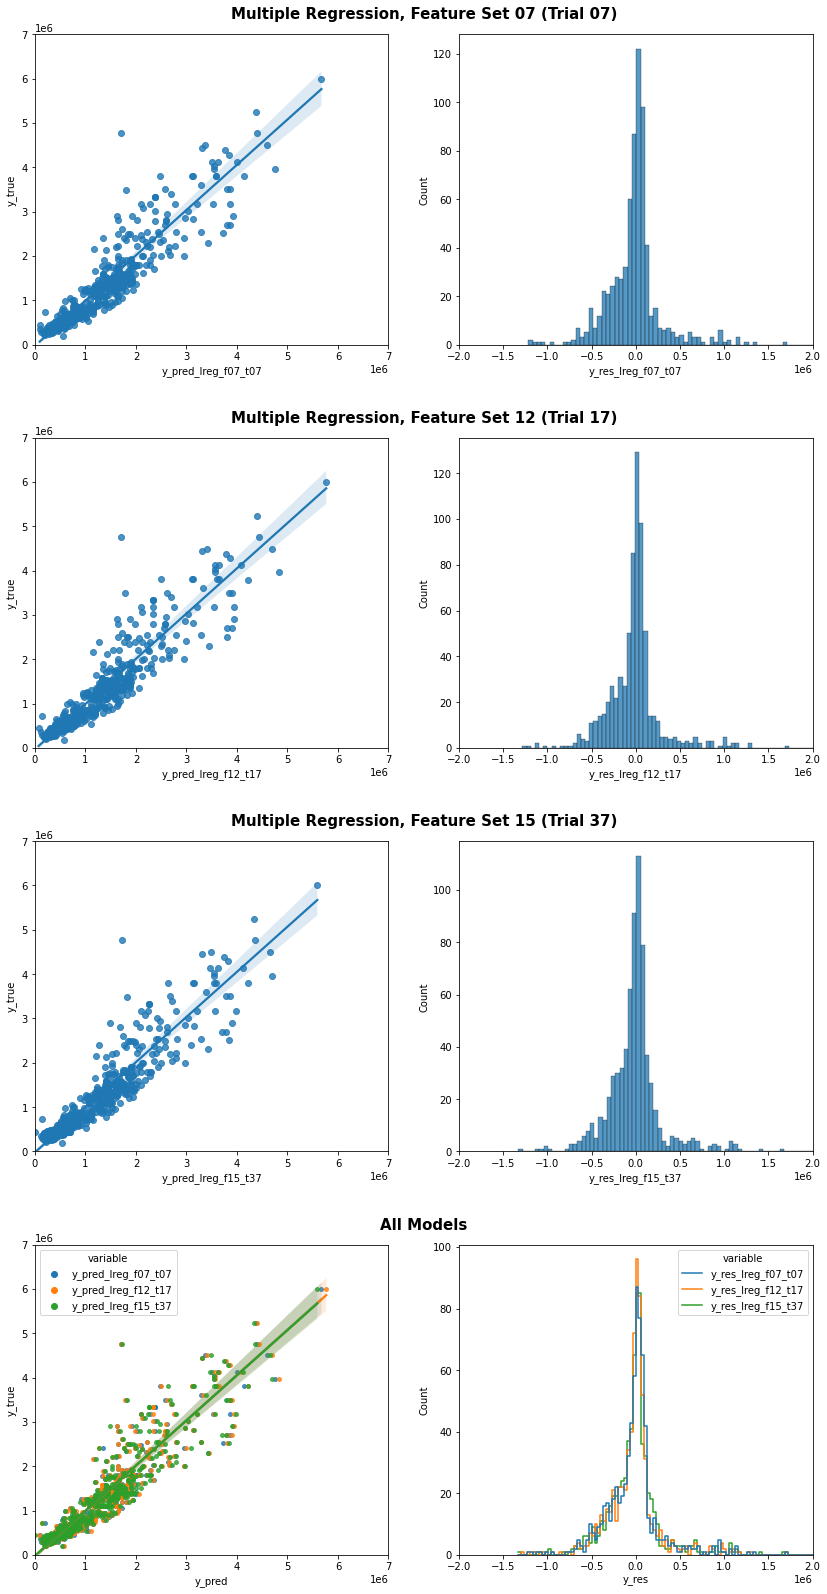

In [95]:
l = [c for c in df_pred.columns.values if ('lreg' in c) or (c == 'y_true')]
plot_prediction_summary(df_pred[l])

### LGBM Regressor

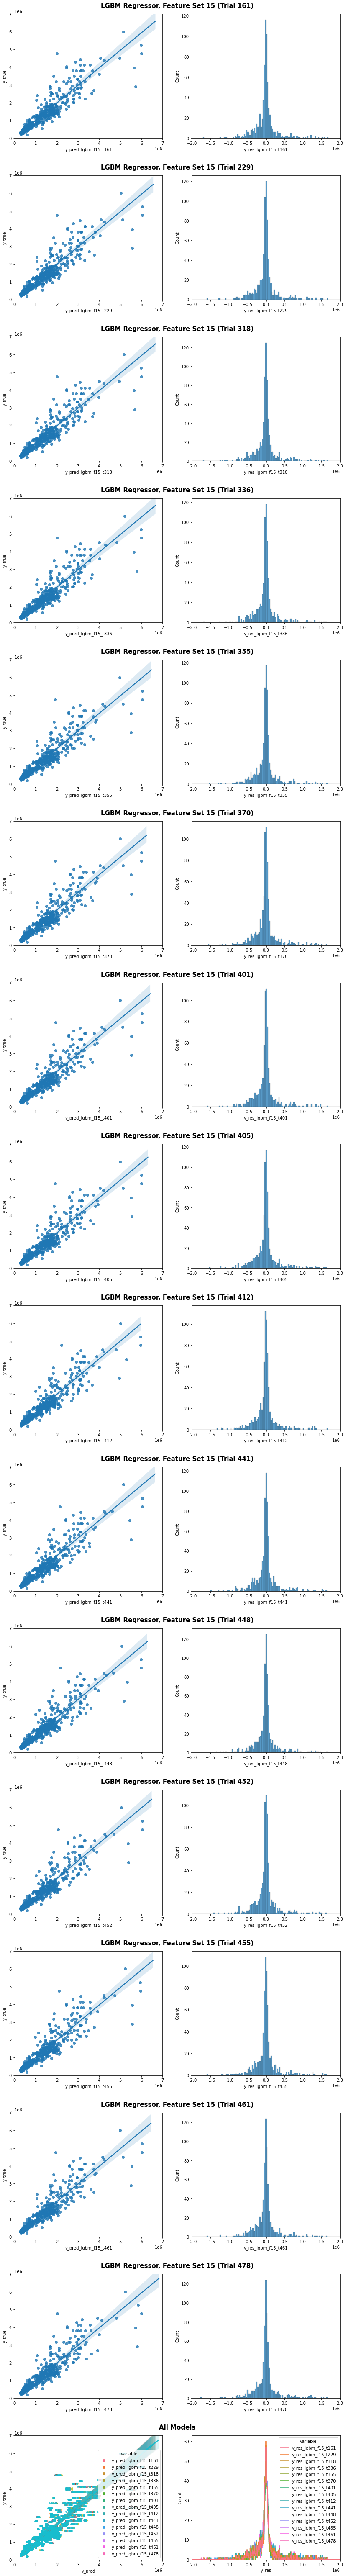

In [96]:
l = [c for c in df_pred.columns.values if ('lgbm' in c) or (c == 'y_true')]
plot_prediction_summary(df_pred[l])

### XGBoost Regressor

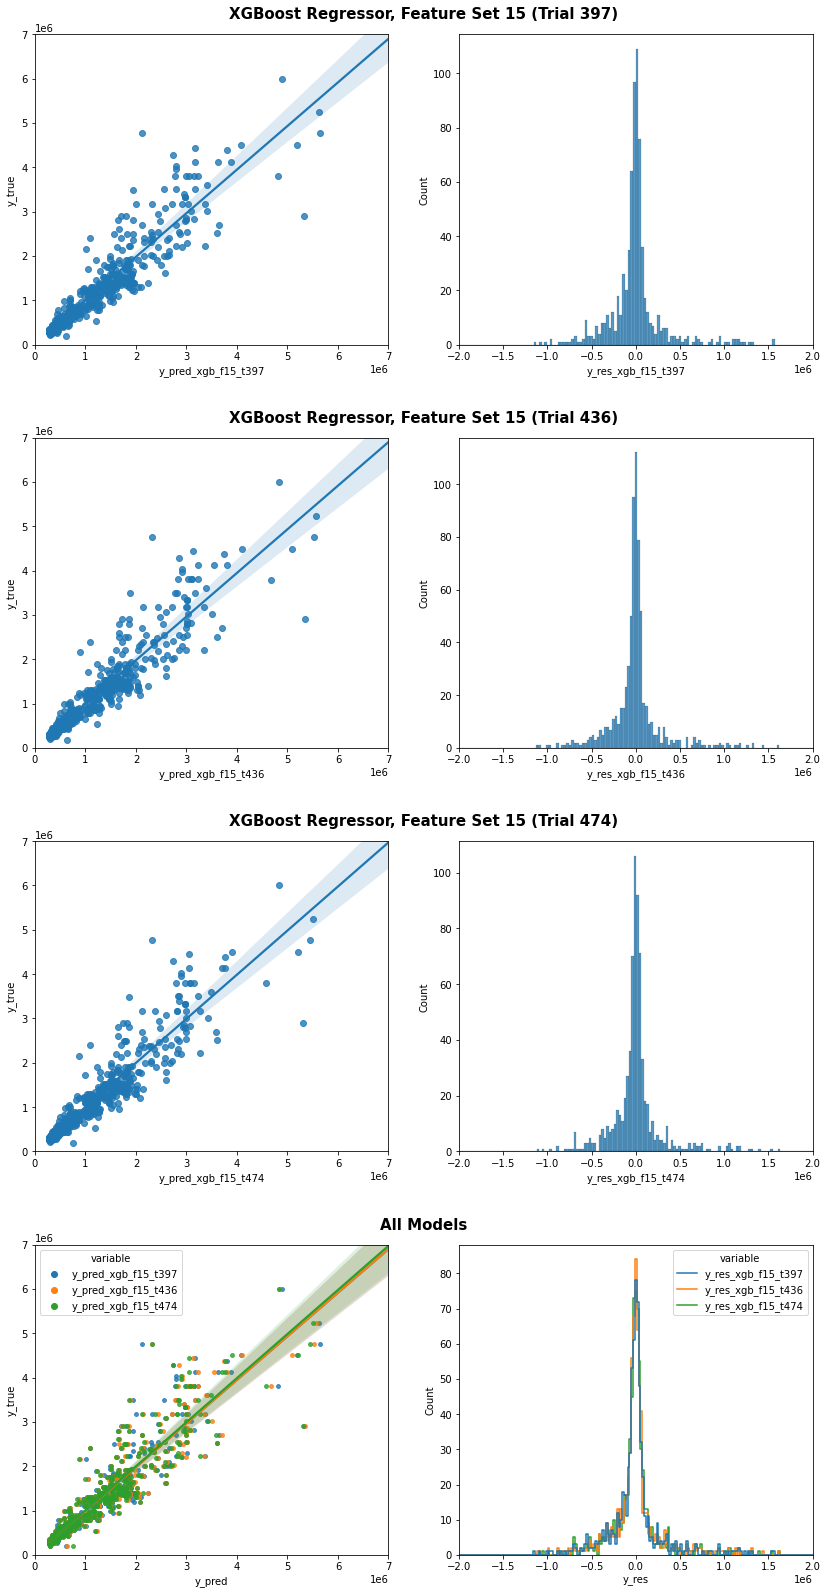

In [99]:
l = [c for c in df_pred.columns.values if ('xgb' in c) or (c == 'y_true')]
plot_prediction_summary(df_pred[l])

### CatBoost Regressor

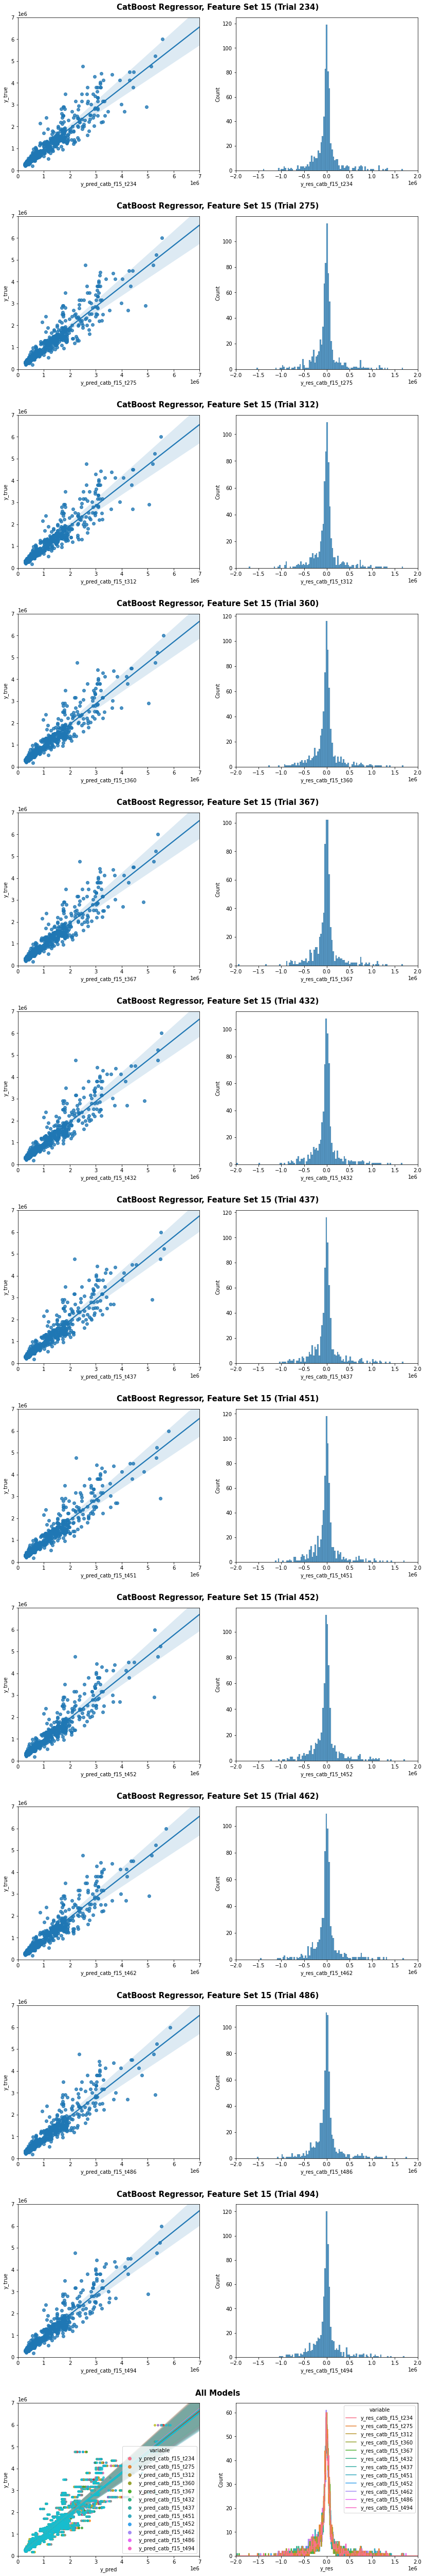

In [100]:
l = [c for c in df_pred.columns.values if ('catb' in c) or (c == 'y_true')]
plot_prediction_summary(df_pred[l])

In [102]:
df_eval_tmp = df_eval.sort_values(by=['mape', 'mae'])
print(df_eval_tmp.shape)
df_eval_tmp.style.background_gradient(
    cmap='Greens_r',
    subset=['mse', 'rmse', 'mae', 'mape']
)

(33, 8)


,mse,rmse,mae,mape,r2_score,model,feature_set,trial
19,145418654584.752533,381337.979468,183102.191259,0.140978,0.856964,xgb,15,436
20,143147505261.232178,378348.391382,182782.207649,0.141202,0.859198,xgb,15,474
30,185460406559.325165,430651.142526,186292.269456,0.143286,0.817578,catb,15,462
23,192847918448.771271,439144.530250,187504.914293,0.143627,0.810311,catb,15,312
21,191136760020.670990,437191.902968,187999.926376,0.143931,0.811995,catb,15,234
31,180494093467.526794,424845.964401,186744.710831,0.144062,0.822463,catb,15,486
22,191086074053.317139,437133.931482,186959.610000,0.144149,0.812044,catb,15,275
11,131890797554.890060,363167.726478,184580.646514,0.144296,0.870270,lgbm,15,412
13,137094195810.775528,370262.333773,185890.410403,0.144300,0.865152,lgbm,15,448
25,182431955770.326233,427120.540094,186904.734256,0.145087,0.820557,catb,15,367


Let's recall the different sets of features we used as predictors: <br>

| Feature Set | Feature columns | 
| --- | --- |
| 1 | Surface | 
| 2 | Bedrooms | 
| 3 | Bathrooms | 
| 4 | Location | 
| 5 | Surface, Bedrooms | 
| 6 | Surface, Bathrooms | 
| 7 | Surface, Location | 
| 8 | Bedrooms, Bathrooms | 
| 9 | Bedrooms, Location |
| 10 | Bathrooms, Location |
| 11 | Surface, Bedrooms, Bathrooms |
| 12 | Surface, Bedrooms, Location |
| 13 | Surface, Bathrooms, Location | 
| 14 | Bedrooms, Bathrooms, Location | 
| 15 | Surface, Bedrooms, Bathrooms, Location | 

## Conclusions 

From the figure and dataframe above, we can extract some observations: 

- As we may intuitively have expected, all the top best-performing models (considering them as the ones ranked with lower MAPE and MAE) were trained using the feature set 15, which includes all the predictor features in the dataset. That is, in this case it seems that the more data we include in the training process, the better the performance of the trained model is. <br>

- The features *Surface* and *Location* seem to be the most important *Price* predictors, as they're included in the best-performing models found for all the tested algorithms. Although only using *Surface* and *Location* (feature set 7) as predictors can lead to good results, still significantly better model predictions are obtained including additional information from *Bedrooms* (feature set 12) and *Bathrooms* (feature set 15) values. <br>

- Based on our criterion (lower MAPE and MAE) the best-performing models are two models trained using the XGBoost Regressor algorithm and all the available predictor features (feature set 15). These model show the lowest MAE (~183102 and ~182782 CLP) and MAPE (0.140978% and 0.141202%) among the best-performing models obtained for all the algorithm tested. In the next notebook we will use these two models to make averaged predictions the training and 
test sets and compare their geospatial distributions. 